In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import seaborn as sns
from patsy import dmatrix, build_design_matrices
from scipy.stats import multivariate_normal
from itertools import cycle
import re
from scipy.linalg import pinv
from scipy.integrate import simpson

sns.set_theme()
sns.set_context("notebook")

In [36]:
dtype_dict = {
    'Date': 'str',
    'FarmName_Pseudo': 'str',
    'SE_Number': 'str',
    'Age': 'Int64',
    'BreedName': 'str',
    'DailyYield': 'float',
    'PreviousDailyYield': 'float',
    'DailyYieldChange': 'float',
    'DaysInMilk': 'Int64',
    'YearSeason': 'str',
    'LactationNumber': 'Int64',
    'ExpectedYield': 'float',
    'NormalizedDailyYield': 'float',
    'NormalizedDailyYieldChange': 'float',
    'HeatStress': 'Int64',
    'Temp15Threshold': 'Int64',
    'HW': 'Int64',
    'cum_HW': 'Int64',
    'MeanTemperature': 'float',
    'MeanTHI_adj': 'float',
    'HeatLoad': 'float',
    'CumulativeHeatLoad': 'float',
}

milk_data = pd.read_csv('../Data/MergedData/HeatApproachCleanedYieldDataTestQuantile.csv', dtype=dtype_dict)
milk_data['Date'] = pd.to_datetime(milk_data['Date'], format='%Y-%m-%d')
milk_data.head(-5)

,Date,FarmName_Pseudo,SE_Number,Age,BreedName,LactationNumber,DaysInMilk,YearSeason,DailyYield,PreviousDailyYield,...,NormalizedDailyYieldChange,Residuals,HeatStress,Temp15Threshold,HW,cum_HW,MeanTemperature,MeanTHI_adj,HeatLoad,CumulativeHeatLoad
0,2022-11-25,5b581702,SE-27c3257a-1492,773,DairyCross,1,32,202204,39.60,NaN,...,NaN,6.630949,0,0,0,0,1.500000,37.235887,-23.764113,0.0
1,2022-11-26,5b581702,SE-27c3257a-1492,774,DairyCross,1,33,202204,22.19,39.60,...,-0.528276,-10.766278,0,0,0,0,1.450000,36.869260,-24.130740,0.0
2,2022-11-27,5b581702,SE-27c3257a-1492,775,DairyCross,1,34,202204,29.40,22.19,...,0.218860,-3.543505,0,0,0,0,-0.150000,30.678900,-30.321100,0.0
3,2022-11-28,5b581702,SE-27c3257a-1492,776,DairyCross,1,35,202204,27.03,29.40,...,-0.071969,-5.900733,0,0,0,0,2.700000,37.007500,-23.992500,0.0
4,2022-11-29,5b581702,SE-27c3257a-1492,777,DairyCross,1,36,202204,26.88,27.03,...,-0.004557,-6.037960,0,0,0,0,2.850000,38.536020,-22.463980,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
289898,2023-04-07,ad0a39f5,SE-ad0a39f5-2805,869,SLB,1,156,202302,47.71,45.67,...,0.043832,1.169136,0,0,0,0,1.366667,35.780160,-25.219840,0.0
289899,2023-04-08,ad0a39f5,SE-ad0a39f5-2805,870,SLB,1,157,202302,50.91,47.71,...,0.069170,4.647419,0,0,0,0,4.700000,43.447053,-17.552947,0.0
289900,2023-04-09,ad0a39f5,SE-ad0a39f5-2805,871,SLB,1,158,202302,46.53,50.91,...,-0.094332,0.098447,0,0,0,0,4.233333,44.991420,-16.008580,0.0
289901,2023-04-10,ad0a39f5,SE-ad0a39f5-2805,872,SLB,1,159,202302,37.26,46.53,...,-0.198830,-9.362667,0,0,0,0,6.066667,45.551007,-15.448993,0.0


# Farm a624fb9a

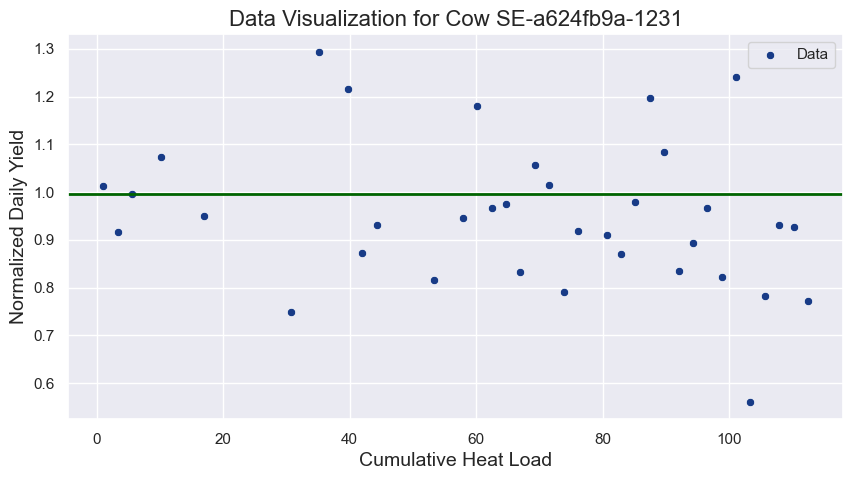

In [37]:
# Filter data for the specific farm
farm_id = 'a624fb9a'
farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm_id]

# Get unique cows (SE_Number) in the farm
unique_cows = farm_data['SE_Number'].unique()

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['FarmName_Pseudo', 'SE_Number', 'CumHeatLoadMilkProduction [%]'])

# Select a random cow for plotting (you can set seed for reproducibility)
np.random.seed(42)  # For reproducibility
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Data Preparation
    N = 50  # Number of bins
    input_feature_label = 'CumulativeHeatLoad'
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Calculate mean_yield for this cow
    mean_yield = cow_data['NormalizedDailyYield'].mean()

    # Initial Visualization (for a random cow only)
    if se_number == random_cow:
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        scatter = sns.scatterplot(x=x, y=y, label='Data', color='#183B87', ax=ax)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        
        plt.title(f"Data Visualization for Cow {se_number}", fontsize=16)
        plt.xlabel('Cumulative Heat Load', fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)
        plt.show()

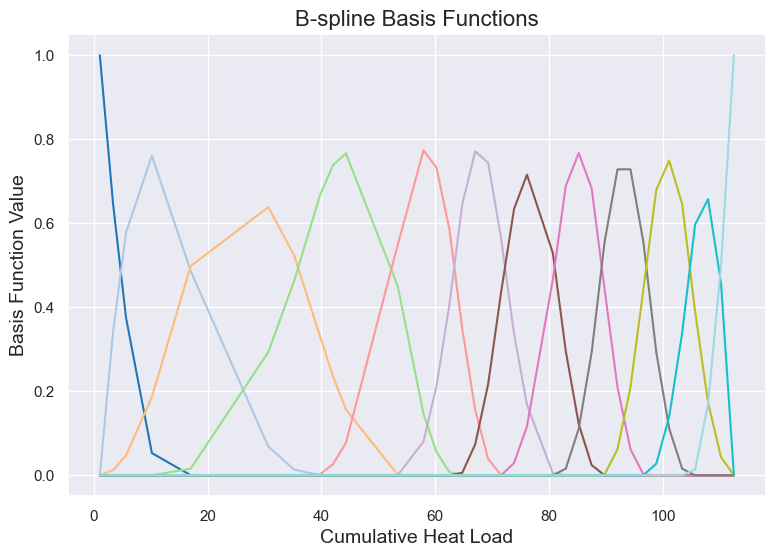

In [38]:
def Phi(a, knots, degree=3, spline_type='B'):
    lower_bound = min(a)
    upper_bound = max(a)
    
    # Adjust knots to ensure they are within the bounds
    knots = np.clip(knots, lower_bound, upper_bound)
    
    if spline_type == 'B':
        B = dmatrix(f"bs(x, knots=knots, degree={degree}, include_intercept=True) - 1", {"x": a, 'knots': knots})
    elif spline_type == 'CR':
        B = dmatrix(f"cr(x, knots=knots, constraints='center')- 1", {"x": a, 'knots': knots})
    elif spline_type == 'CC':
        B = dmatrix(f"cc(x, knots=knots, constraints='center') - 1", {"x": a, 'knots': knots})
    else:
        raise ValueError(f"{spline_type} is not a valid type, choose from 'B', 'CC' or 'CR'")
    return B


for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs+1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Plot Basis Functions (for the random cow)
    if se_number == random_cow:
        color_map = plt.colormaps.get_cmap('tab20')
        colors = color_map(np.linspace(0, 1, B.shape[1]))

        fig = plt.figure(figsize=(9, 6))
        ax = plt.subplot(111)
        for i in range(B.shape[1]):
            c = colors[i]
            ax.plot(x, B[:, i], c=c, label=f'Basis {i + 1}')

        plt.title('B-spline Basis Functions', fontsize=16)
        plt.xlabel('Cumulative Heat Load', fontsize=14)
        plt.ylabel('Basis Function Value', fontsize=14)
        plt.show()

Mean squared error for Cow SE-a624fb9a-1231 is 0.0194


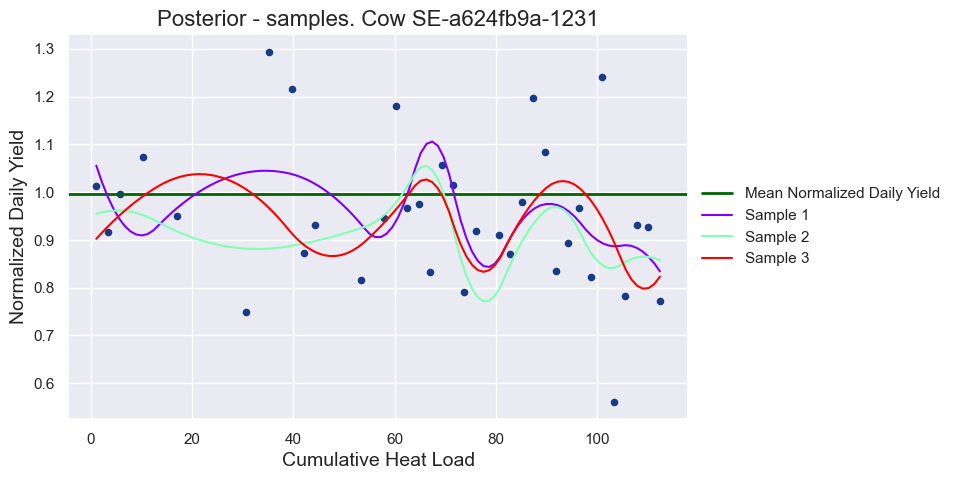

In [39]:
# Seed for reproducibility
np.random.seed(42)

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Check if there are enough data points
    if len(y) < 2:  # If fewer than 2 data points, skip this cow
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Block 3: Bayesian Linear Regression - GAM
    # Calculate empirical priors from the data
    D = B.shape[1]
    m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
    S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

    if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
        print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
        continue

    beta = 1 / np.var(y)

    if np.isinf(beta) or np.isnan(beta):
        print(f"Skipping Cow {se_number} due to invalid beta value.")
        continue

    # Compute the posterior distribution with new priors
    SN = pinv(pinv(S0) + beta * B.T @ B)

    # Adding a small regularization term to ensure positive semi-definiteness
    regularization_term = 1e-6 * np.eye(D)
    SN += regularization_term

    mN = SN @ (pinv(S0) @ m0 + beta * B.T @ y)

    # Print MSE for this cow
    mse = np.mean((y - B @ mN) ** 2)

    # Plot the posterior for the random cow
    if se_number == random_cow:
        print(f"Mean squared error for Cow {se_number} is {mse:.4f}")
        samples = 3
        seed = 100
        ws = multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed)

        n = 100  # number of grid-points
        xs = np.linspace(x.min(), x.max(), n)
        new_data = {'x': xs}

        B_star = build_design_matrices([B.design_info], new_data)[0]
        B_star = np.asarray(B_star)

        # Compute corresponding values f(x*)
        fs = B_star @ ws.T

        # Plot the samples
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        plt.scatter(x, y, color='#183B87', zorder=1, s=20)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

        color = cycle(cm.rainbow(np.linspace(0, 1, samples)))
        for i in range(ws.shape[0]):
            c = next(color)
            line, = ax.plot(xs, fs[:, i], c=c, label=f"Sample {i+1}")

        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)  # Set legend transparency

        plt.title(f'Posterior - samples. Cow {se_number}', fontsize=16)
        plt.xlabel(re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label), fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)  # Updated ylabel

        plt.show()

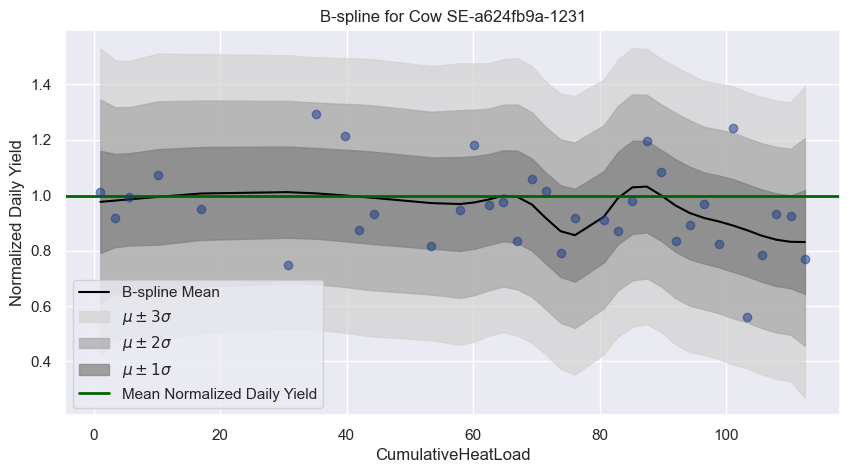

,FarmName_Pseudo,SE_Number,HeatMilkProduction [%],HeatMilkProduction
0,a624fb9a,SE-30dc5787-1389,-1.463621,-0.014636
1,a624fb9a,SE-a624fb9a-1162,-0.994174,-0.009942
2,a624fb9a,SE-a624fb9a-1199,-2.469995,-0.024700
3,a624fb9a,SE-a624fb9a-1200,-4.567066,-0.045671
4,a624fb9a,SE-a624fb9a-1257,-0.723162,-0.007232
...,...,...,...,...
117,a624fb9a,SE-a624fb9a-1471,1.174031,0.011740
118,a624fb9a,SE-a624fb9a-1508,-2.571781,-0.025718
119,a624fb9a,SE-a624fb9a-1517,-0.983622,-0.009836
120,a624fb9a,SE-a624fb9a-1531,1.969187,0.019692


In [40]:
# Seed for reproducibility
np.random.seed(42)

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['FarmName_Pseudo', 'SE_Number', 'HeatMilkProduction [%]'])

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Ensure sufficient data points
    if len(y) < 2:  # Ensure at least 2 data points
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    try:
        # B-Spline Basis Functions (Primary Method)
        degree_spline = 2  # Change the order of the polynomial here
        max_knots = min(len(y) - 1, 10)
        num_qs = max_knots
        knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])
        B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

        # Check if B has more rows than columns
        if B.shape[0] < B.shape[1]:
            raise ValueError(f"Incompatible dimensions (B: {B.shape})")

        # Step 1: Calculate empirical priors from the correct data
        m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
        S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

        if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
            print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
            continue

        # Bayesian Linear Regression
        beta = 1 / np.var(y)
        lambda_ridge = 0.1
        SN = np.linalg.pinv(np.linalg.pinv(S0) + beta * B.T @ B + lambda_ridge * np.eye(B.shape[1]))
        mN = SN @ (np.linalg.pinv(S0) @ m0 + beta * B.T @ y)

        # Make predictions
        mstar_mle = B @ mN
        Sstar_mle = B @ SN @ B.T + beta ** (-1) * np.eye(B.shape[0])
        stdpred_mle = np.sqrt(np.diag(Sstar_mle))
        model_type = 'B-spline'

    except Exception as e:
        print(f"Skipping Cow {se_number} due to incompatible dimensions or another error: {str(e)}")
        continue

    # Integration to calculate HeatMilkProduction
    above_mean = np.maximum(mstar_mle - mean_yield, 0)
    below_mean = np.maximum(mean_yield - mstar_mle, 0)

    # Integrate using the original x values
    area_above_mean = simpson(above_mean, x=x)
    area_below_mean = simpson(below_mean, x=x)

    # Calculate the net area (above - below)
    net_area = area_above_mean - area_below_mean
    range_cum_heatload = x[-1] - x[0]
    net_effect_per_unit = net_area / range_cum_heatload

    # Express the net effect as a percentage of the mean yield
    net_effect_percentage = (net_effect_per_unit / mean_yield) * 100

    # Store results in the DataFrame
    new_result = pd.DataFrame([{
        'FarmName_Pseudo': farm_id,
        'SE_Number': se_number,
        'HeatMilkProduction [%]': net_effect_percentage
    }])

    if results_df.empty:
        results_df = new_result
    else:
        results_df = pd.concat([results_df, new_result], ignore_index=True)

    # Plot for the randomly selected cow
    if se_number == random_cow:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(x, mstar_mle, 'black', label=f'{model_type} Mean')
        ax.fill_between(x, mstar_mle + 3*stdpred_mle, mstar_mle - 3*stdpred_mle, color='lightgray', alpha=0.7, label=r'$\mu \pm 3\sigma$')
        ax.fill_between(x, mstar_mle + 2*stdpred_mle, mstar_mle - 2*stdpred_mle, color='darkgray', alpha=0.7, label=r'$\mu \pm 2\sigma$')
        ax.fill_between(x, mstar_mle + 1*stdpred_mle, mstar_mle - 1*stdpred_mle, color='gray', alpha=0.7, label=r'$\mu \pm 1\sigma$')
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        plt.scatter(x, y, c='#183B87', zorder=4, alpha=0.5)
        ax.legend(loc='best')
        plt.title(f'{model_type} for Cow {se_number}')
        plt.xlabel(f'{input_feature_label}')
        plt.ylabel('Normalized Daily Yield')
        plt.show()

# Display the results
results_df['HeatMilkProduction'] = results_df['HeatMilkProduction [%]'] / 100
results_df

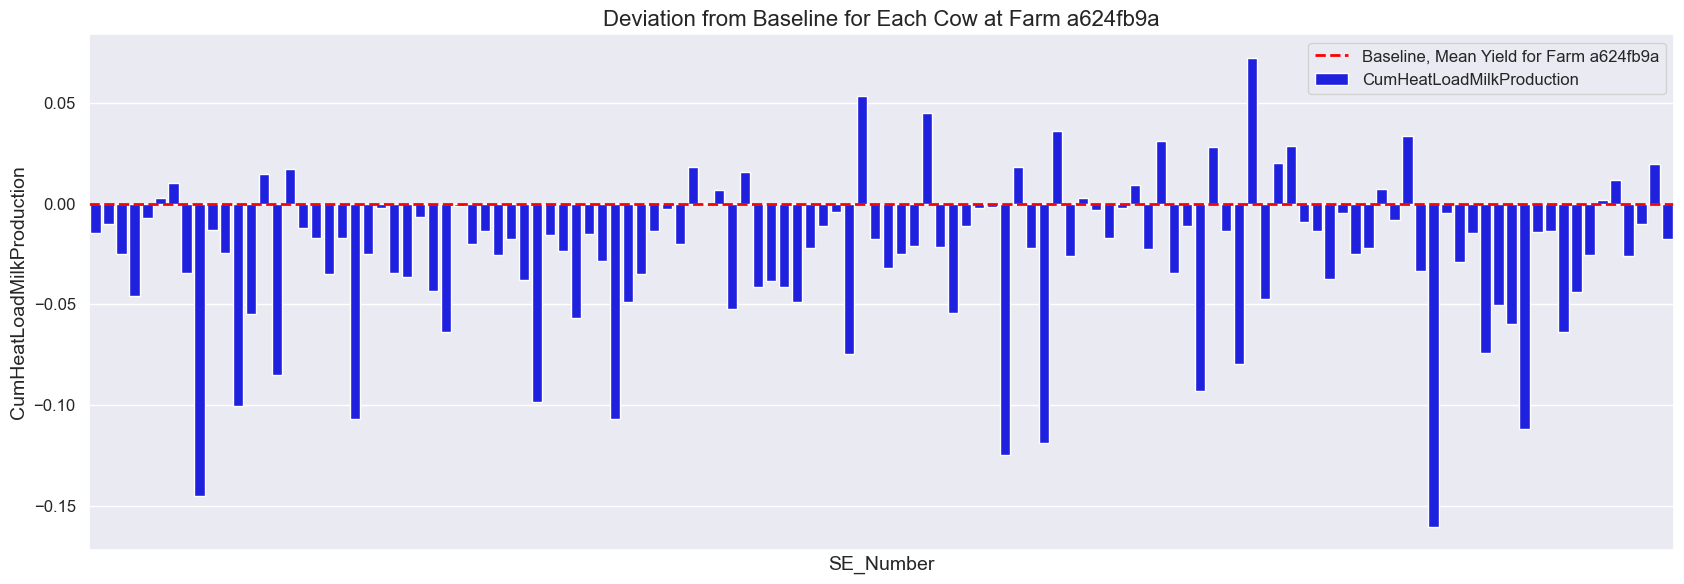

In [41]:
# Create the bar plot
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['HeatMilkProduction'], color='blue', label='CumHeatLoadMilkProduction')

# Add a baseline line set to 0
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')

# Formatting the plot
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('CumHeatLoadMilkProduction', fontsize=14)
plt.title(f'Deviation from Baseline for Each Cow at Farm {farm_id}', fontsize=16)

# Optionally, remove x-axis labels if too many entries
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

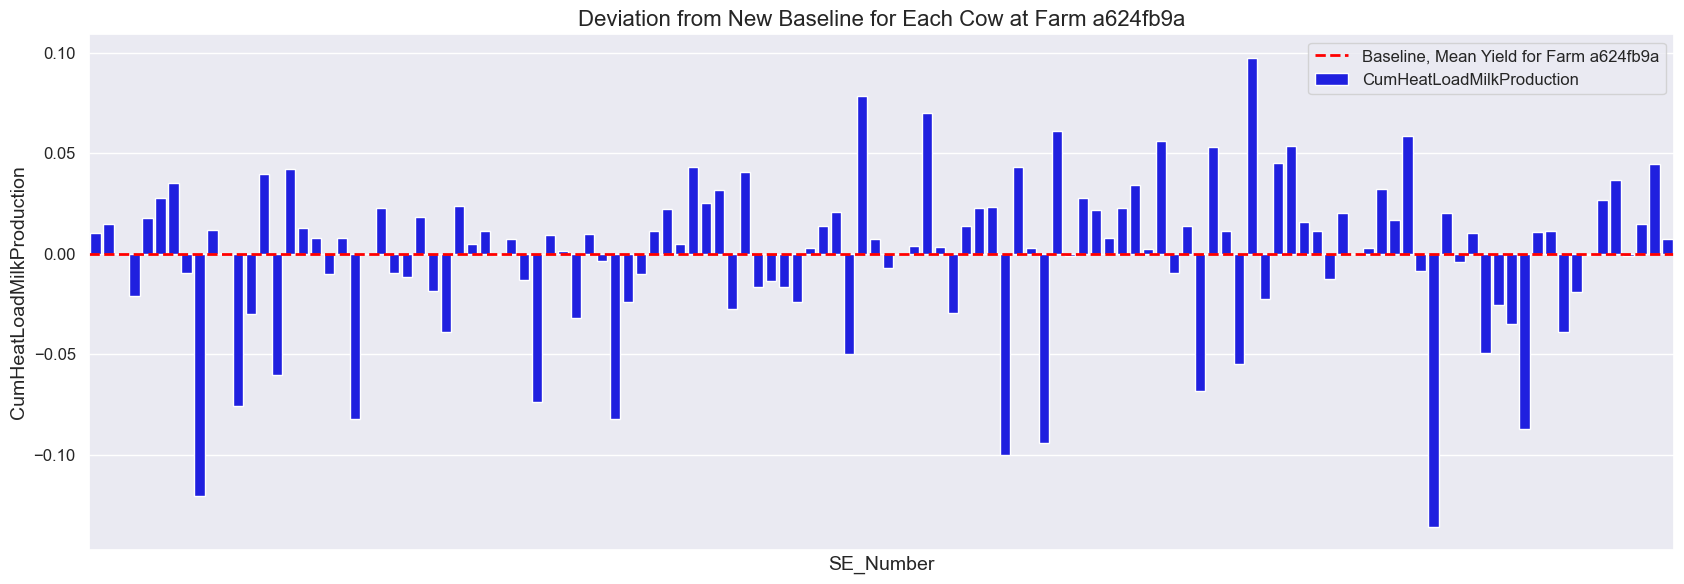

In [42]:
# New baseline value
new_baseline = results_df['HeatMilkProduction'].mean()

# Adjust the HeatMilkProduction to start from the new baseline
results_df['AdjustedHeatMilkProduction'] = results_df['HeatMilkProduction'] - new_baseline

# Create the bar plot
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['AdjustedHeatMilkProduction'], color='blue', label='CumHeatLoadMilkProduction')

# Add a baseline line set to 0 (now adjusted to the new baseline)
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')

# Formatting the plot
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('CumHeatLoadMilkProduction', fontsize=14)
plt.title(f'Deviation from New Baseline for Each Cow at Farm {farm_id}', fontsize=16)

# Optionally, remove x-axis labels if too many entries
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

# Farm 5c06d92d

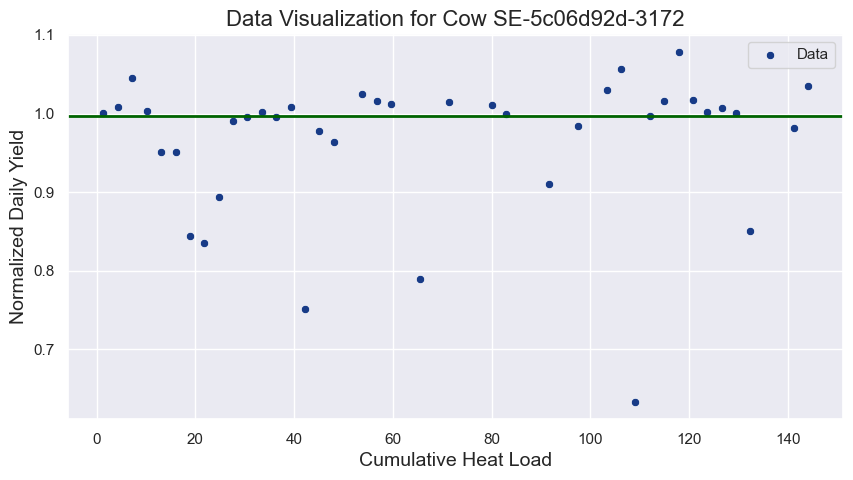

In [43]:
# Filter data for the specific farm
farm_id = '5c06d92d'
farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm_id]

# Get unique cows (SE_Number) in the farm
unique_cows = farm_data['SE_Number'].unique()

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['FarmName_Pseudo', 'SE_Number', 'CumHeatLoadMilkProduction [%]'])

# Select a random cow for plotting (you can set seed for reproducibility)
np.random.seed(42)  # For reproducibility
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Data Preparation
    N = 50  # Number of bins
    input_feature_label = 'CumulativeHeatLoad'
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Calculate mean_yield for this cow
    mean_yield = cow_data['NormalizedDailyYield'].mean()

    # Initial Visualization (for a random cow only)
    if se_number == random_cow:
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        scatter = sns.scatterplot(x=x, y=y, label='Data', color='#183B87', ax=ax)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        
        plt.title(f"Data Visualization for Cow {se_number}", fontsize=16)
        plt.xlabel('Cumulative Heat Load', fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)
        plt.show()

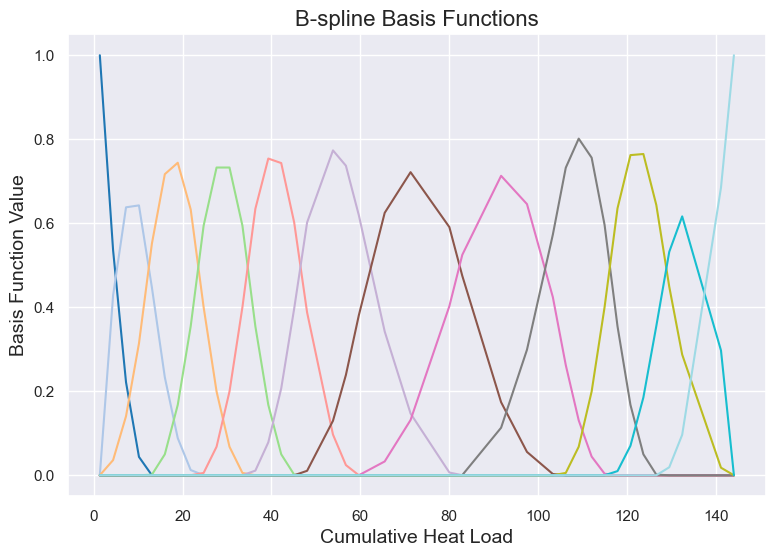

In [44]:
def Phi(a, knots, degree=3, spline_type='B'):
    lower_bound = min(a)
    upper_bound = max(a)
    
    # Adjust knots to ensure they are within the bounds
    knots = np.clip(knots, lower_bound, upper_bound)
    
    if spline_type == 'B':
        B = dmatrix(f"bs(x, knots=knots, degree={degree}, include_intercept=True) - 1", {"x": a, 'knots': knots})
    elif spline_type == 'CR':
        B = dmatrix(f"cr(x, knots=knots, constraints='center')- 1", {"x": a, 'knots': knots})
    elif spline_type == 'CC':
        B = dmatrix(f"cc(x, knots=knots, constraints='center') - 1", {"x": a, 'knots': knots})
    else:
        raise ValueError(f"{spline_type} is not a valid type, choose from 'B', 'CC' or 'CR'")
    return B


for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs+1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Plot Basis Functions (for the random cow)
    if se_number == random_cow:
        color_map = plt.colormaps.get_cmap('tab20')
        colors = color_map(np.linspace(0, 1, B.shape[1]))

        fig = plt.figure(figsize=(9, 6))
        ax = plt.subplot(111)
        for i in range(B.shape[1]):
            c = colors[i]
            ax.plot(x, B[:, i], c=c, label=f'Basis {i + 1}')

        plt.title('B-spline Basis Functions', fontsize=16)
        plt.xlabel('Cumulative Heat Load', fontsize=14)
        plt.ylabel('Basis Function Value', fontsize=14)
        plt.show()

Mean squared error for Cow SE-5c06d92d-3172 is 0.0056


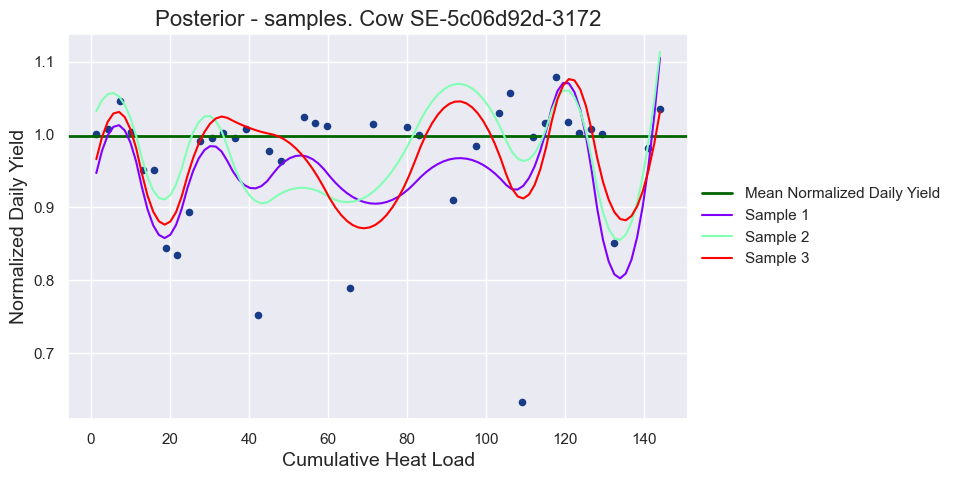

In [45]:
# Seed for reproducibility
np.random.seed(42)

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Check if there are enough data points
    if len(y) < 2:  # If fewer than 2 data points, skip this cow
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Block 3: Bayesian Linear Regression - GAM
    # Calculate empirical priors from the data
    D = B.shape[1]
    m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
    S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

    if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
        print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
        continue

    beta = 1 / np.var(y)

    if np.isinf(beta) or np.isnan(beta):
        print(f"Skipping Cow {se_number} due to invalid beta value.")
        continue

    # Compute the posterior distribution with new priors
    SN = pinv(pinv(S0) + beta * B.T @ B)

    # Adding a small regularization term to ensure positive semi-definiteness
    regularization_term = 1e-6 * np.eye(D)
    SN += regularization_term

    mN = SN @ (pinv(S0) @ m0 + beta * B.T @ y)

    # Print MSE for this cow
    mse = np.mean((y - B @ mN) ** 2)

    # Plot the posterior for the random cow
    if se_number == random_cow:
        print(f"Mean squared error for Cow {se_number} is {mse:.4f}")
        samples = 3
        seed = 100
        ws = multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed)

        n = 100  # number of grid-points
        xs = np.linspace(x.min(), x.max(), n)
        new_data = {'x': xs}

        B_star = build_design_matrices([B.design_info], new_data)[0]
        B_star = np.asarray(B_star)

        # Compute corresponding values f(x*)
        fs = B_star @ ws.T

        # Plot the samples
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        plt.scatter(x, y, color='#183B87', zorder=1, s=20)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

        color = cycle(cm.rainbow(np.linspace(0, 1, samples)))
        for i in range(ws.shape[0]):
            c = next(color)
            line, = ax.plot(xs, fs[:, i], c=c, label=f"Sample {i+1}")

        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)  # Set legend transparency

        plt.title(f'Posterior - samples. Cow {se_number}', fontsize=16)
        plt.xlabel(re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label), fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)  # Updated ylabel

        plt.show()

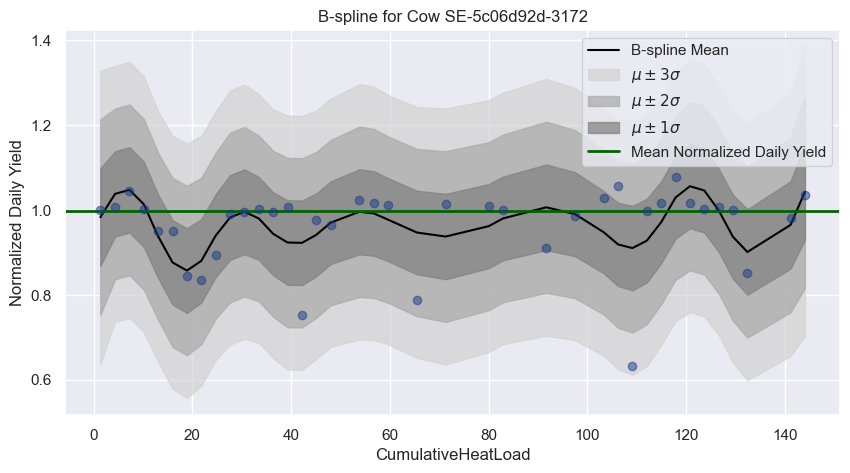

Skipping Cow SE-5c06d92d-2990 due to incompatible dimensions or another error: Incompatible dimensions (B: (3, 4))


,FarmName_Pseudo,SE_Number,HeatMilkProduction [%],HeatMilkProduction
0,5c06d92d,SE-5c06d92d-2055,-8.598504,-0.085985
1,5c06d92d,SE-5c06d92d-2424,-1.065835,-0.010658
2,5c06d92d,SE-5c06d92d-2457,-9.151443,-0.091514
3,5c06d92d,SE-5c06d92d-2470,-2.055870,-0.020559
4,5c06d92d,SE-5c06d92d-2478,-0.710634,-0.007106
...,...,...,...,...
350,5c06d92d,SE-5c06d92d-3562,1.300354,0.013004
351,5c06d92d,SE-5c06d92d-3565,0.829760,0.008298
352,5c06d92d,SE-5c06d92d-3573,0.841492,0.008415
353,5c06d92d,SE-5c06d92d-3580,1.792823,0.017928


In [46]:
# Seed for reproducibility
np.random.seed(42)

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['FarmName_Pseudo', 'SE_Number', 'HeatMilkProduction [%]'])

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Ensure sufficient data points
    if len(y) < 2:  # Ensure at least 2 data points
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    try:
        # B-Spline Basis Functions (Primary Method)
        degree_spline = 2  # Change the order of the polynomial here
        max_knots = min(len(y) - 1, 10)
        num_qs = max_knots
        knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])
        B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

        # Check if B has more rows than columns
        if B.shape[0] < B.shape[1]:
            raise ValueError(f"Incompatible dimensions (B: {B.shape})")

        # Step 1: Calculate empirical priors from the correct data
        m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
        S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

        if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
            print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
            continue

        # Bayesian Linear Regression
        beta = 1 / np.var(y)
        lambda_ridge = 0.1
        SN = np.linalg.pinv(np.linalg.pinv(S0) + beta * B.T @ B + lambda_ridge * np.eye(B.shape[1]))
        mN = SN @ (np.linalg.pinv(S0) @ m0 + beta * B.T @ y)

        # Make predictions
        mstar_mle = B @ mN
        Sstar_mle = B @ SN @ B.T + beta ** (-1) * np.eye(B.shape[0])
        stdpred_mle = np.sqrt(np.diag(Sstar_mle))
        model_type = 'B-spline'

    except Exception as e:
        print(f"Skipping Cow {se_number} due to incompatible dimensions or another error: {str(e)}")
        continue

    # Integration to calculate HeatMilkProduction
    above_mean = np.maximum(mstar_mle - mean_yield, 0)
    below_mean = np.maximum(mean_yield - mstar_mle, 0)

    # Integrate using the original x values
    area_above_mean = simpson(above_mean, x=x)
    area_below_mean = simpson(below_mean, x=x)

    # Calculate the net area (above - below)
    net_area = area_above_mean - area_below_mean
    range_cum_heatload = x[-1] - x[0]
    net_effect_per_unit = net_area / range_cum_heatload

    # Express the net effect as a percentage of the mean yield
    net_effect_percentage = (net_effect_per_unit / mean_yield) * 100

    # Store results in the DataFrame
    new_result = pd.DataFrame([{
        'FarmName_Pseudo': farm_id,
        'SE_Number': se_number,
        'HeatMilkProduction [%]': net_effect_percentage
    }])

    if results_df.empty:
        results_df = new_result
    else:
        results_df = pd.concat([results_df, new_result], ignore_index=True)

    # Plot for the randomly selected cow
    if se_number == random_cow:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(x, mstar_mle, 'black', label=f'{model_type} Mean')
        ax.fill_between(x, mstar_mle + 3*stdpred_mle, mstar_mle - 3*stdpred_mle, color='lightgray', alpha=0.7, label=r'$\mu \pm 3\sigma$')
        ax.fill_between(x, mstar_mle + 2*stdpred_mle, mstar_mle - 2*stdpred_mle, color='darkgray', alpha=0.7, label=r'$\mu \pm 2\sigma$')
        ax.fill_between(x, mstar_mle + 1*stdpred_mle, mstar_mle - 1*stdpred_mle, color='gray', alpha=0.7, label=r'$\mu \pm 1\sigma$')
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        plt.scatter(x, y, c='#183B87', zorder=4, alpha=0.5)
        ax.legend(loc='best')
        plt.title(f'{model_type} for Cow {se_number}')
        plt.xlabel(f'{input_feature_label}')
        plt.ylabel('Normalized Daily Yield')
        plt.show()

# Display the results
results_df['HeatMilkProduction'] = results_df['HeatMilkProduction [%]'] / 100
results_df

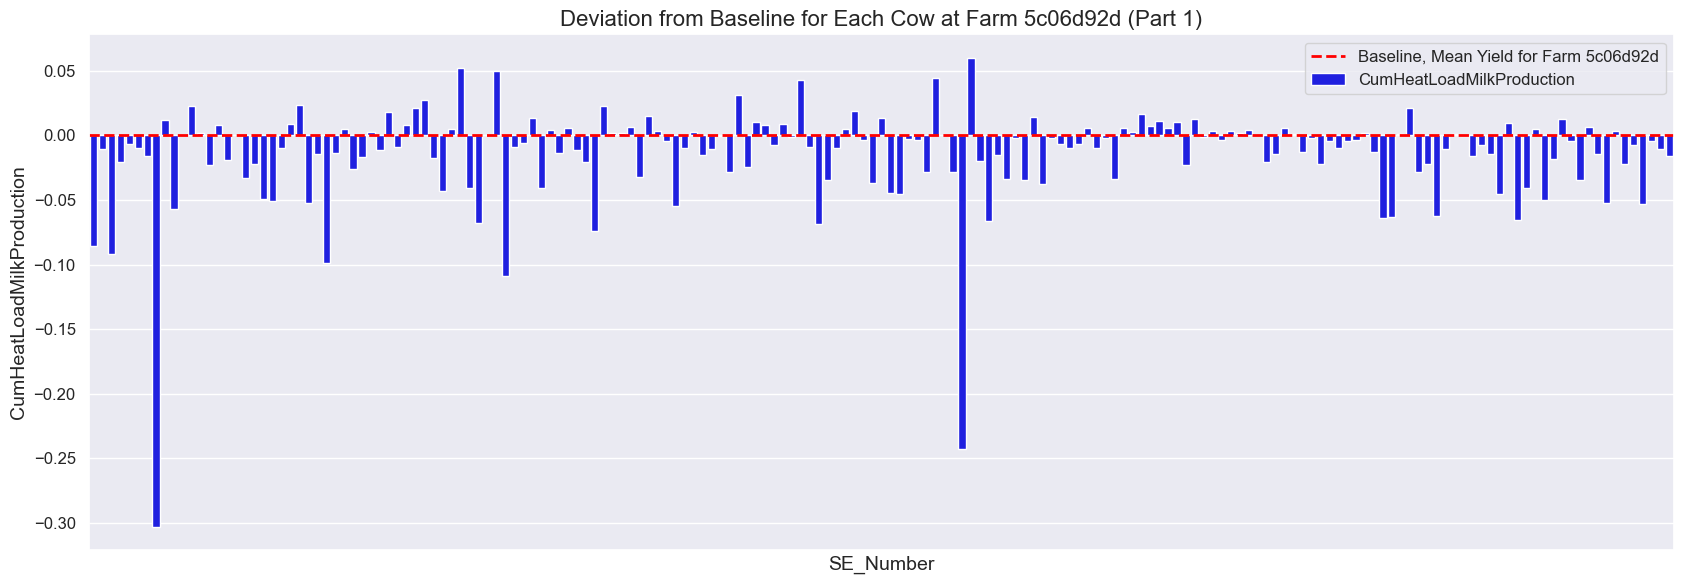

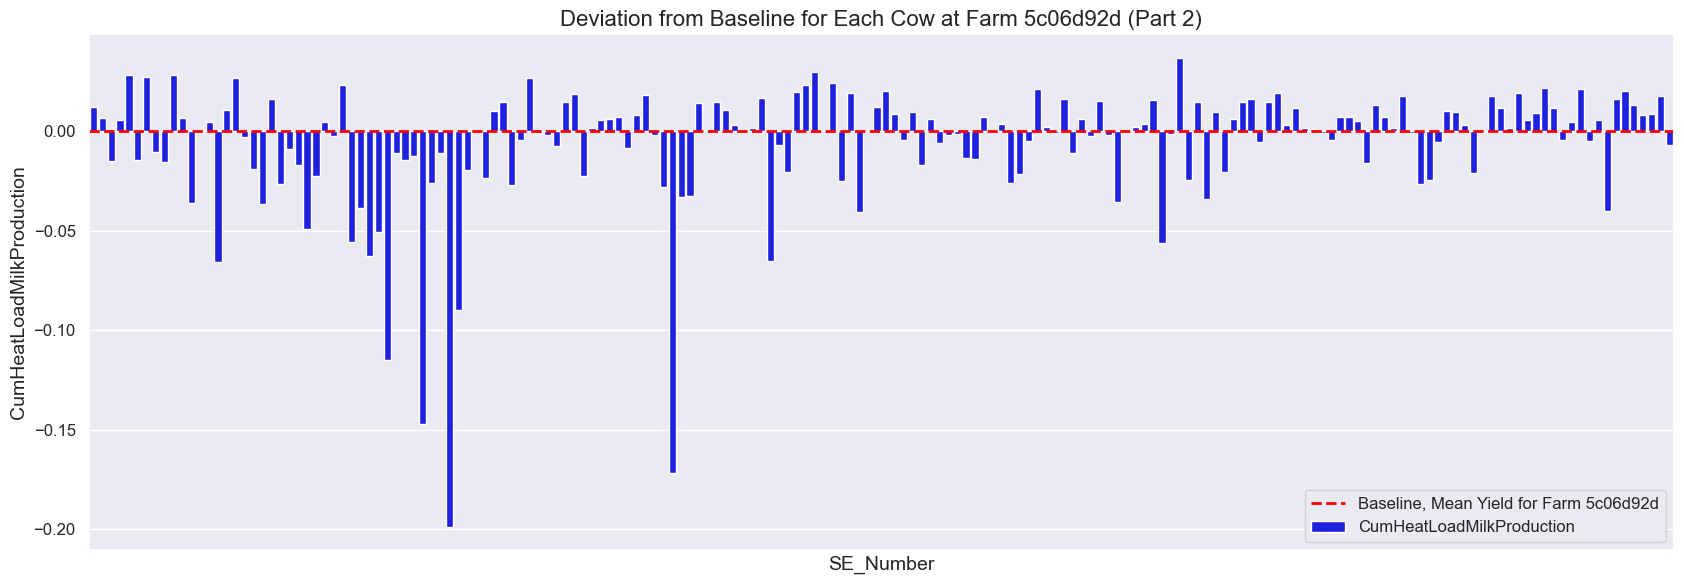

In [47]:
# Calculate the midpoint to split the data into two halves
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['HeatMilkProduction'], color='blue', label='CumHeatLoadMilkProduction')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('CumHeatLoadMilkProduction', fontsize=14)
plt.title(f'Deviation from Baseline for Each Cow at Farm {farm_id} (Part 1)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['HeatMilkProduction'], color='blue', label='CumHeatLoadMilkProduction')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('CumHeatLoadMilkProduction', fontsize=14)
plt.title(f'Deviation from Baseline for Each Cow at Farm {farm_id} (Part 2)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

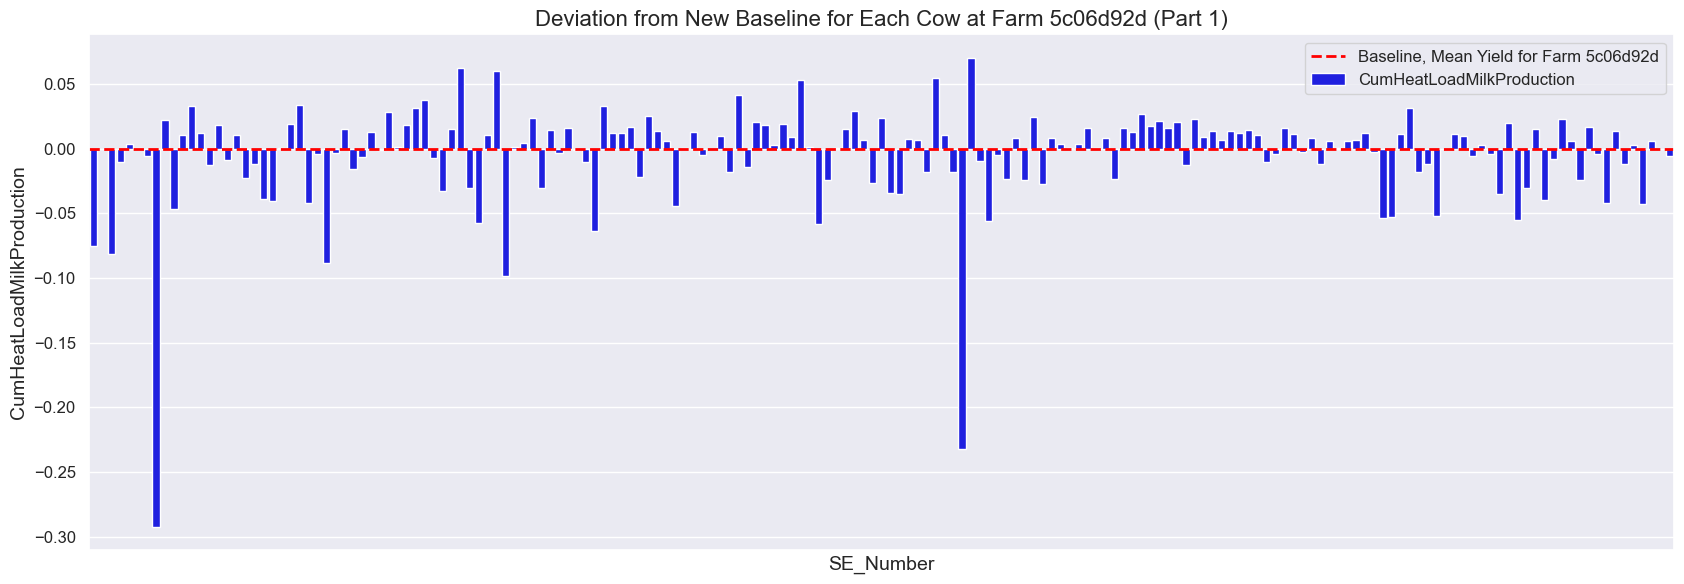

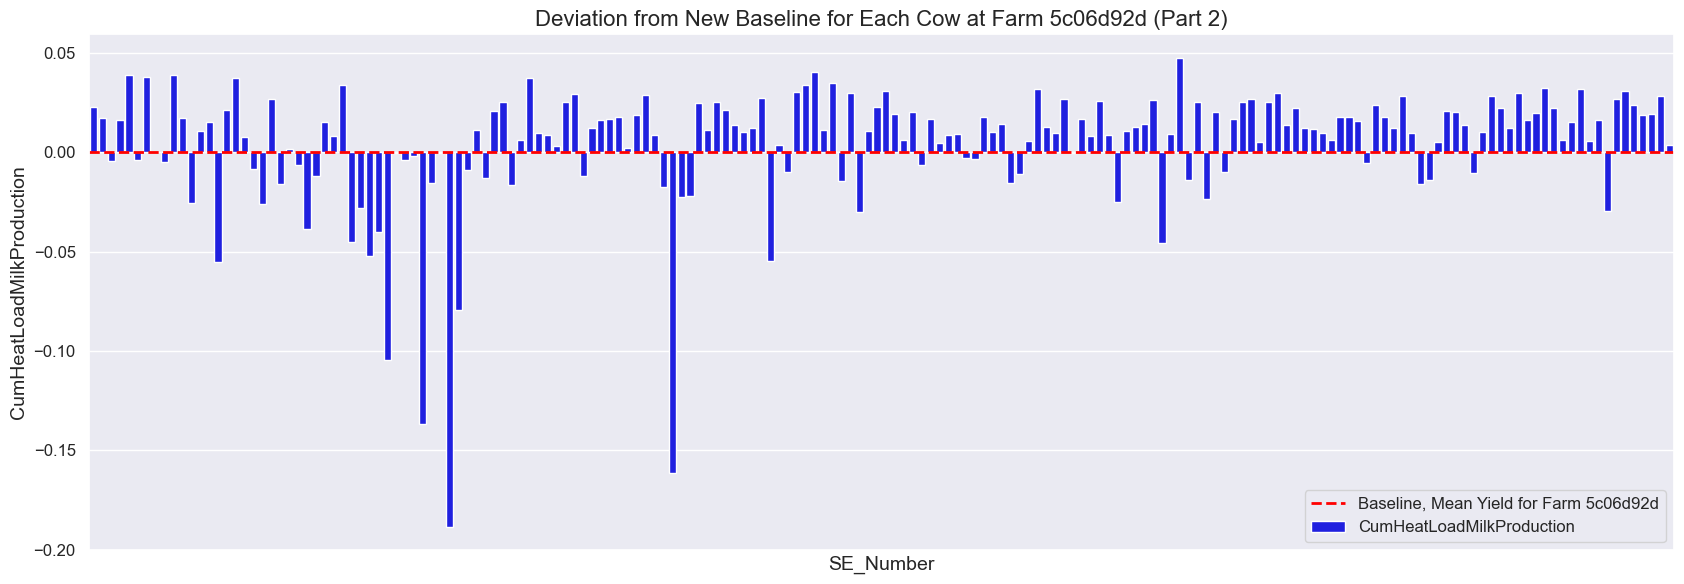

In [48]:
# New baseline value
new_baseline = results_df['HeatMilkProduction'].mean()

# Adjust the HeatMilkProduction to start from the new baseline
results_df['AdjustedHeatMilkProduction'] = results_df['HeatMilkProduction'] - new_baseline

# Calculate the midpoint to split the data into two halves
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['AdjustedHeatMilkProduction'], color='blue', label='CumHeatLoadMilkProduction')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('CumHeatLoadMilkProduction', fontsize=14)
plt.title(f'Deviation from New Baseline for Each Cow at Farm {farm_id} (Part 1)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['AdjustedHeatMilkProduction'], color='blue', label='CumHeatLoadMilkProduction')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('CumHeatLoadMilkProduction', fontsize=14)
plt.title(f'Deviation from New Baseline for Each Cow at Farm {farm_id} (Part 2)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

## Farm 752efd72
- Herd not in P. Ask-Gullstrand's filtered dataset

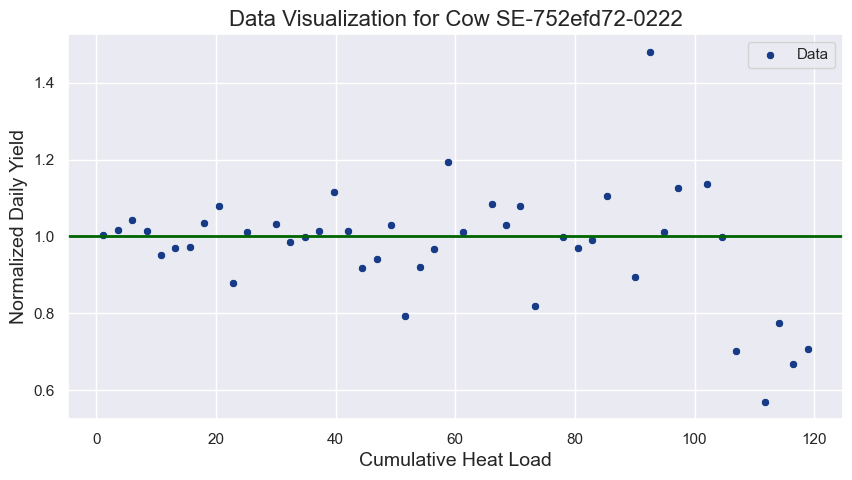

In [15]:
# Filter data for the specific farm
farm_id = '752efd72'
farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm_id]

# Get unique cows (SE_Number) in the farm
unique_cows = farm_data['SE_Number'].unique()

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['FarmName_Pseudo', 'SE_Number', 'CumHeatLoadMilkProduction [%]'])

# Select a random cow for plotting (you can set seed for reproducibility)
np.random.seed(42)  # For reproducibility
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Data Preparation
    N = 50  # Number of bins
    input_feature_label = 'CumulativeHeatLoad'
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Calculate mean_yield for this cow
    mean_yield = cow_data['NormalizedDailyYield'].mean()

    # Initial Visualization (for a random cow only)
    if se_number == random_cow:
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        scatter = sns.scatterplot(x=x, y=y, label='Data', color='#183B87', ax=ax)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        
        plt.title(f"Data Visualization for Cow {se_number}", fontsize=16)
        plt.xlabel('Cumulative Heat Load', fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)
        plt.show()

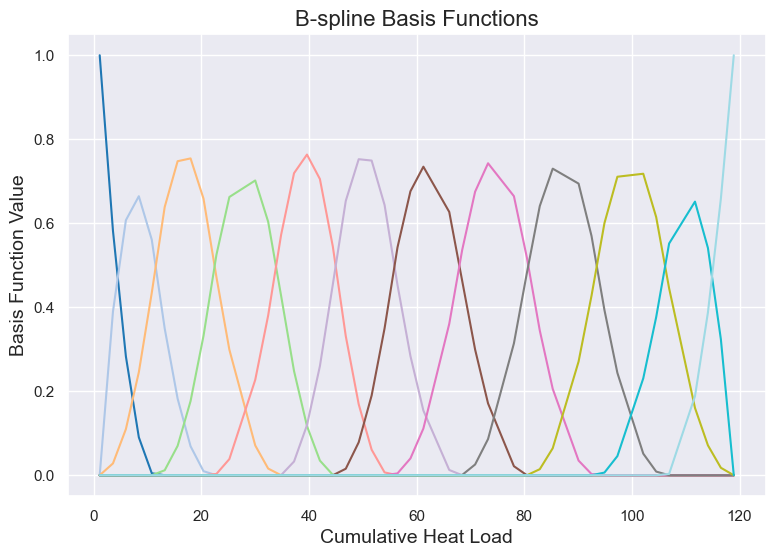

In [16]:
def Phi(a, knots, degree=3, spline_type='B'):
    lower_bound = min(a)
    upper_bound = max(a)
    
    # Adjust knots to ensure they are within the bounds
    knots = np.clip(knots, lower_bound, upper_bound)
    
    if spline_type == 'B':
        B = dmatrix(f"bs(x, knots=knots, degree={degree}, include_intercept=True) - 1", {"x": a, 'knots': knots})
    elif spline_type == 'CR':
        B = dmatrix(f"cr(x, knots=knots, constraints='center')- 1", {"x": a, 'knots': knots})
    elif spline_type == 'CC':
        B = dmatrix(f"cc(x, knots=knots, constraints='center') - 1", {"x": a, 'knots': knots})
    else:
        raise ValueError(f"{spline_type} is not a valid type, choose from 'B', 'CC' or 'CR'")
    return B


for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs+1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Plot Basis Functions (for the random cow)
    if se_number == random_cow:
        color_map = plt.colormaps.get_cmap('tab20')
        colors = color_map(np.linspace(0, 1, B.shape[1]))

        fig = plt.figure(figsize=(9, 6))
        ax = plt.subplot(111)
        for i in range(B.shape[1]):
            c = colors[i]
            ax.plot(x, B[:, i], c=c, label=f'Basis {i + 1}')

        plt.title('B-spline Basis Functions', fontsize=16)
        plt.xlabel('Cumulative Heat Load', fontsize=14)
        plt.ylabel('Basis Function Value', fontsize=14)
        plt.show()

Mean squared error for Cow SE-752efd72-0222 is 0.0084


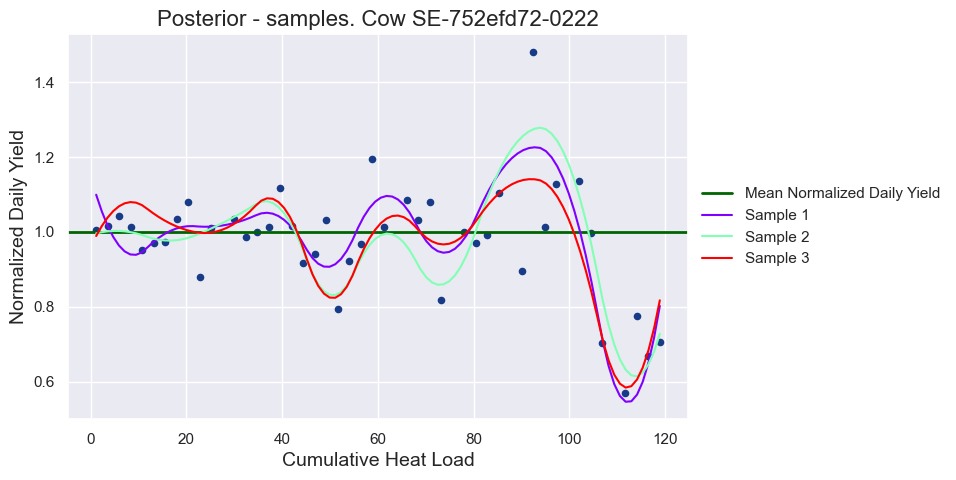

In [17]:
# Seed for reproducibility
np.random.seed(42)

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Check if there are enough data points
    if len(y) < 2:  # If fewer than 2 data points, skip this cow
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Block 3: Bayesian Linear Regression - GAM
    # Calculate empirical priors from the data
    D = B.shape[1]
    m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
    S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

    if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
        print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
        continue

    beta = 1 / np.var(y)

    if np.isinf(beta) or np.isnan(beta):
        print(f"Skipping Cow {se_number} due to invalid beta value.")
        continue

    # Compute the posterior distribution with new priors
    SN = pinv(pinv(S0) + beta * B.T @ B)

    # Adding a small regularization term to ensure positive semi-definiteness
    regularization_term = 1e-6 * np.eye(D)
    SN += regularization_term

    mN = SN @ (pinv(S0) @ m0 + beta * B.T @ y)

    # Print MSE for this cow
    mse = np.mean((y - B @ mN) ** 2)

    # Plot the posterior for the random cow
    if se_number == random_cow:
        print(f"Mean squared error for Cow {se_number} is {mse:.4f}")
        samples = 3
        seed = 100
        ws = multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed)

        n = 100  # number of grid-points
        xs = np.linspace(x.min(), x.max(), n)
        new_data = {'x': xs}

        B_star = build_design_matrices([B.design_info], new_data)[0]
        B_star = np.asarray(B_star)

        # Compute corresponding values f(x*)
        fs = B_star @ ws.T

        # Plot the samples
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        plt.scatter(x, y, color='#183B87', zorder=1, s=20)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

        color = cycle(cm.rainbow(np.linspace(0, 1, samples)))
        for i in range(ws.shape[0]):
            c = next(color)
            line, = ax.plot(xs, fs[:, i], c=c, label=f"Sample {i+1}")

        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)  # Set legend transparency

        plt.title(f'Posterior - samples. Cow {se_number}', fontsize=16)
        plt.xlabel(re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label), fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)  # Updated ylabel

        plt.show()

Skipping Cow SE-752efd72-0093 due to incompatible dimensions or another error: Incompatible dimensions (B: (3, 4))
Skipping Cow SE-752efd72-0163 due to incompatible dimensions or another error: Incompatible dimensions (B: (7, 8))
Skipping Cow SE-752efd72-0174 due to incompatible dimensions or another error: Incompatible dimensions (B: (8, 9))


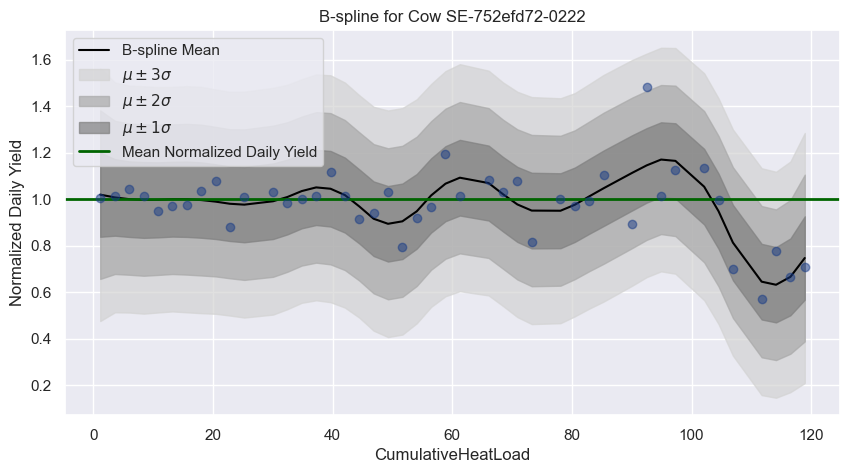

Skipping Cow SE-752efd72-0274 due to incompatible dimensions or another error: Incompatible dimensions (B: (8, 9))
Skipping Cow SE-752efd72-0412 due to incompatible dimensions or another error: Incompatible dimensions (B: (7, 8))
Skipping Cow SE-752efd72-0519 due to incompatible dimensions or another error: Incompatible dimensions (B: (4, 5))
Skipping Cow SE-752efd72-2795 due to incompatible dimensions or another error: Incompatible dimensions (B: (6, 7))


,FarmName_Pseudo,SE_Number,HeatMilkProduction [%],HeatMilkProduction
0,752efd72,SE-752efd72-0001,-1.550799,-0.015508
1,752efd72,SE-752efd72-0002,12.130440,0.121304
2,752efd72,SE-752efd72-0008,-2.755242,-0.027552
3,752efd72,SE-752efd72-0010,-2.944184,-0.029442
4,752efd72,SE-752efd72-0011,-2.136698,-0.021367
...,...,...,...,...
391,752efd72,SE-752efd72-0345,-1.379652,-0.013797
392,752efd72,SE-752efd72-0450,-0.313014,-0.003130
393,752efd72,SE-752efd72-0468,-0.174462,-0.001745
394,752efd72,SE-752efd72-0469,-0.433017,-0.004330


In [18]:
# Seed for reproducibility
np.random.seed(42)

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['FarmName_Pseudo', 'SE_Number', 'HeatMilkProduction [%]'])

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Ensure sufficient data points
    if len(y) < 2:  # Ensure at least 2 data points
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    try:
        # B-Spline Basis Functions (Primary Method)
        degree_spline = 2  # Change the order of the polynomial here
        max_knots = min(len(y) - 1, 10)
        num_qs = max_knots
        knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])
        B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

        # Check if B has more rows than columns
        if B.shape[0] < B.shape[1]:
            raise ValueError(f"Incompatible dimensions (B: {B.shape})")

        # Step 1: Calculate empirical priors from the correct data
        m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
        S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

        if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
            print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
            continue

        # Bayesian Linear Regression
        beta = 1 / np.var(y)
        lambda_ridge = 0.1
        SN = np.linalg.pinv(np.linalg.pinv(S0) + beta * B.T @ B + lambda_ridge * np.eye(B.shape[1]))
        mN = SN @ (np.linalg.pinv(S0) @ m0 + beta * B.T @ y)

        # Make predictions
        mstar_mle = B @ mN
        Sstar_mle = B @ SN @ B.T + beta ** (-1) * np.eye(B.shape[0])
        stdpred_mle = np.sqrt(np.diag(Sstar_mle))
        model_type = 'B-spline'

    except Exception as e:
        print(f"Skipping Cow {se_number} due to incompatible dimensions or another error: {str(e)}")
        continue

    # Integration to calculate HeatMilkProduction
    above_mean = np.maximum(mstar_mle - mean_yield, 0)
    below_mean = np.maximum(mean_yield - mstar_mle, 0)

    # Integrate using the original x values
    area_above_mean = simpson(above_mean, x=x)
    area_below_mean = simpson(below_mean, x=x)

    # Calculate the net area (above - below)
    net_area = area_above_mean - area_below_mean
    range_cum_heatload = x[-1] - x[0]
    net_effect_per_unit = net_area / range_cum_heatload

    # Express the net effect as a percentage of the mean yield
    net_effect_percentage = (net_effect_per_unit / mean_yield) * 100

    # Store results in the DataFrame
    new_result = pd.DataFrame([{
        'FarmName_Pseudo': farm_id,
        'SE_Number': se_number,
        'HeatMilkProduction [%]': net_effect_percentage
    }])

    if results_df.empty:
        results_df = new_result
    else:
        results_df = pd.concat([results_df, new_result], ignore_index=True)

    # Plot for the randomly selected cow
    if se_number == random_cow:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(x, mstar_mle, 'black', label=f'{model_type} Mean')
        ax.fill_between(x, mstar_mle + 3*stdpred_mle, mstar_mle - 3*stdpred_mle, color='lightgray', alpha=0.7, label=r'$\mu \pm 3\sigma$')
        ax.fill_between(x, mstar_mle + 2*stdpred_mle, mstar_mle - 2*stdpred_mle, color='darkgray', alpha=0.7, label=r'$\mu \pm 2\sigma$')
        ax.fill_between(x, mstar_mle + 1*stdpred_mle, mstar_mle - 1*stdpred_mle, color='gray', alpha=0.7, label=r'$\mu \pm 1\sigma$')
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        plt.scatter(x, y, c='#183B87', zorder=4, alpha=0.5)
        ax.legend(loc='best')
        plt.title(f'{model_type} for Cow {se_number}')
        plt.xlabel(f'{input_feature_label}')
        plt.ylabel('Normalized Daily Yield')
        plt.show()

# Display the results
results_df['HeatMilkProduction'] = results_df['HeatMilkProduction [%]'] / 100
results_df

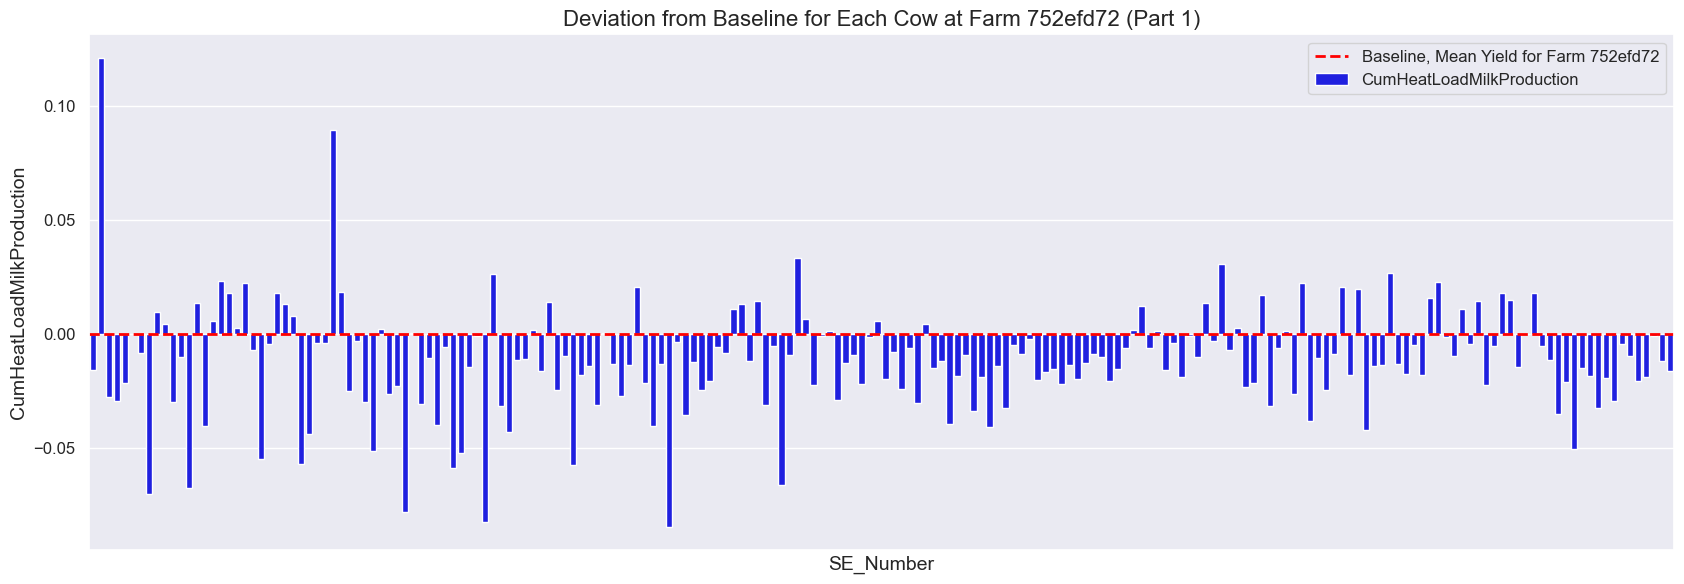

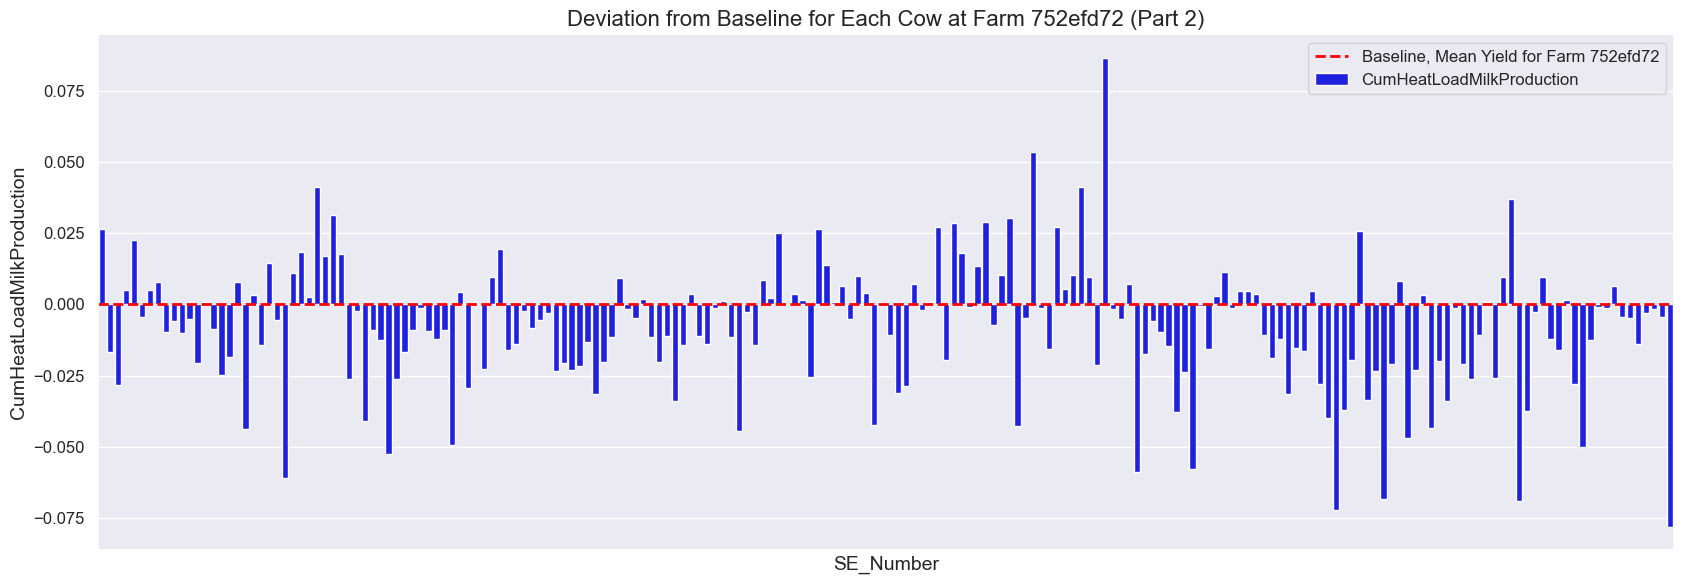

In [19]:
# Calculate the midpoint to split the data into two halves
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['HeatMilkProduction'], color='blue', label='CumHeatLoadMilkProduction')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('CumHeatLoadMilkProduction', fontsize=14)
plt.title(f'Deviation from Baseline for Each Cow at Farm {farm_id} (Part 1)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['HeatMilkProduction'], color='blue', label='CumHeatLoadMilkProduction')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('CumHeatLoadMilkProduction', fontsize=14)
plt.title(f'Deviation from Baseline for Each Cow at Farm {farm_id} (Part 2)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

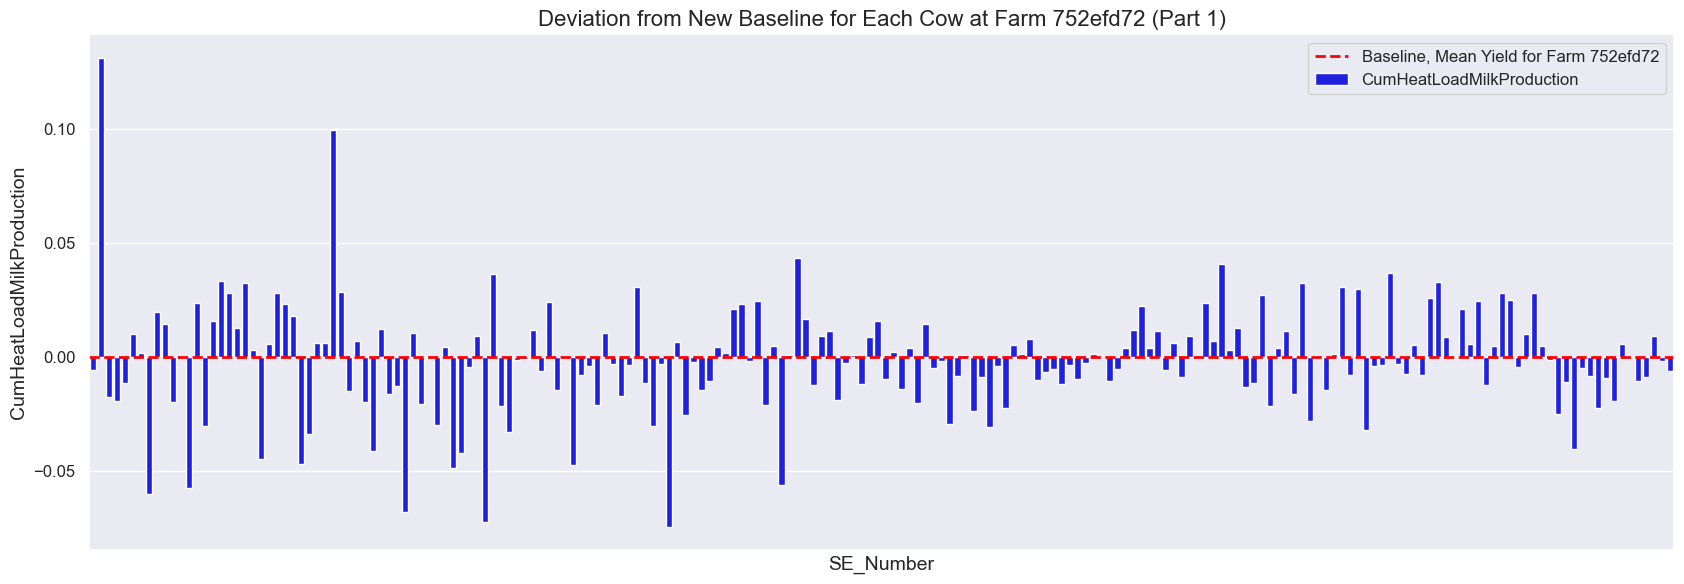

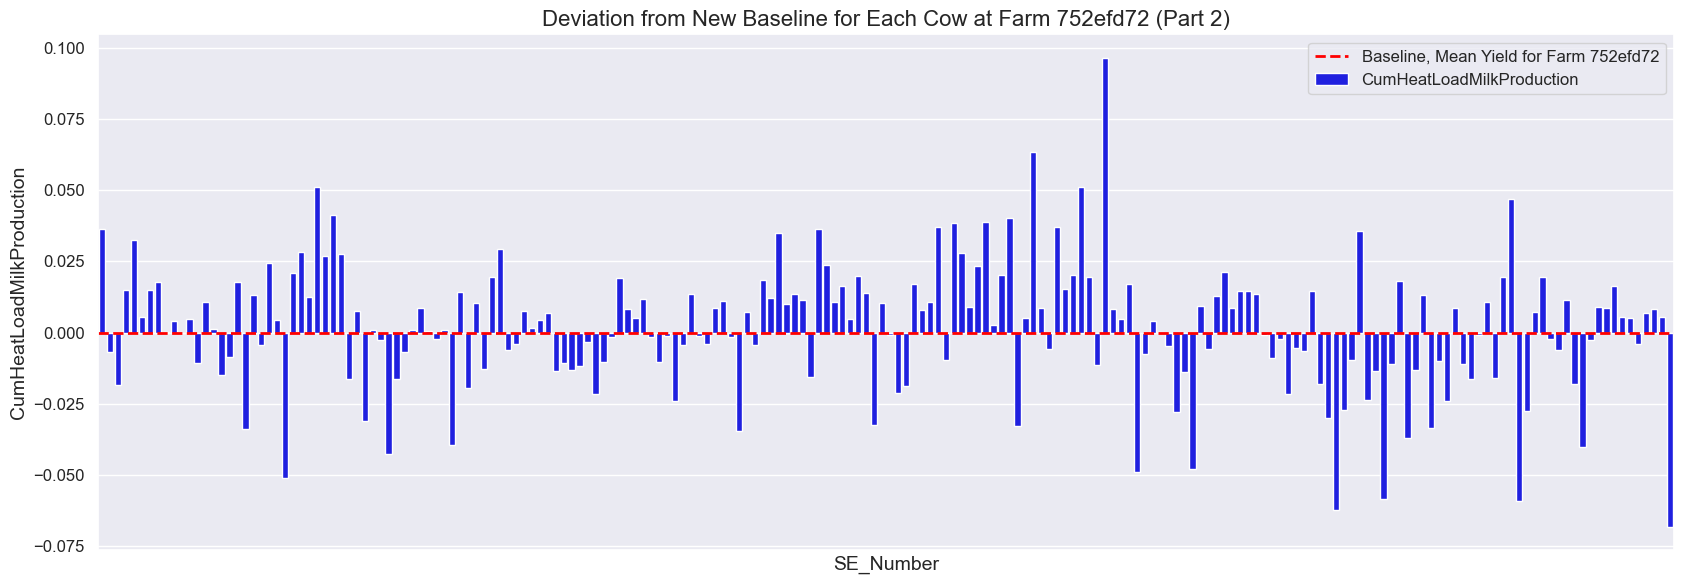

In [20]:
# New baseline value
new_baseline = results_df['HeatMilkProduction'].mean()

# Adjust the HeatMilkProduction to start from the new baseline
results_df['AdjustedHeatMilkProduction'] = results_df['HeatMilkProduction'] - new_baseline

# Calculate the midpoint to split the data into two halves
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['AdjustedHeatMilkProduction'], color='blue', label='CumHeatLoadMilkProduction')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('CumHeatLoadMilkProduction', fontsize=14)
plt.title(f'Deviation from New Baseline for Each Cow at Farm {farm_id} (Part 1)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['AdjustedHeatMilkProduction'], color='blue', label='CumHeatLoadMilkProduction')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('CumHeatLoadMilkProduction', fontsize=14)
plt.title(f'Deviation from New Baseline for Each Cow at Farm {farm_id} (Part 2)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

## Farm f454e660

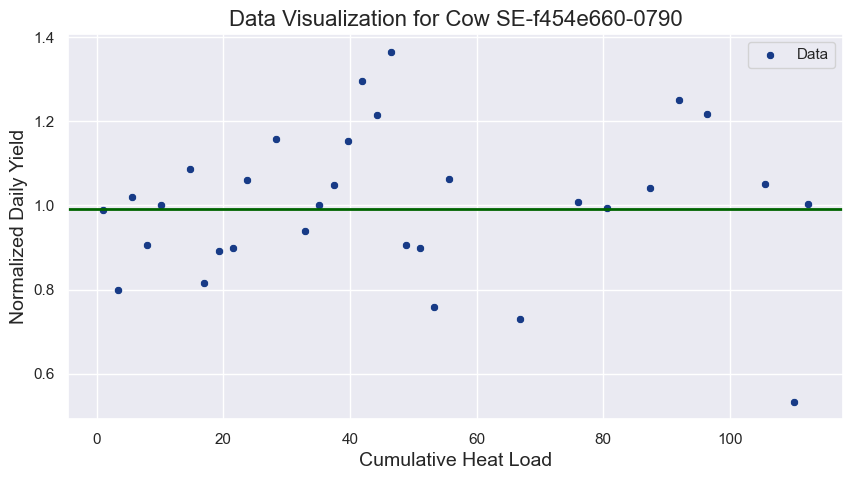

In [49]:
# Filter data for the specific farm
farm_id = 'f454e660'
farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm_id]

# Get unique cows (SE_Number) in the farm
unique_cows = farm_data['SE_Number'].unique()

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['FarmName_Pseudo', 'SE_Number', 'CumHeatLoadMilkProduction [%]'])

# Select a random cow for plotting (you can set seed for reproducibility)
np.random.seed(42)  # For reproducibility
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Data Preparation
    N = 50  # Number of bins
    input_feature_label = 'CumulativeHeatLoad'
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Calculate mean_yield for this cow
    mean_yield = cow_data['NormalizedDailyYield'].mean()

    # Initial Visualization (for a random cow only)
    if se_number == random_cow:
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        scatter = sns.scatterplot(x=x, y=y, label='Data', color='#183B87', ax=ax)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        
        plt.title(f"Data Visualization for Cow {se_number}", fontsize=16)
        plt.xlabel('Cumulative Heat Load', fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)
        plt.show()

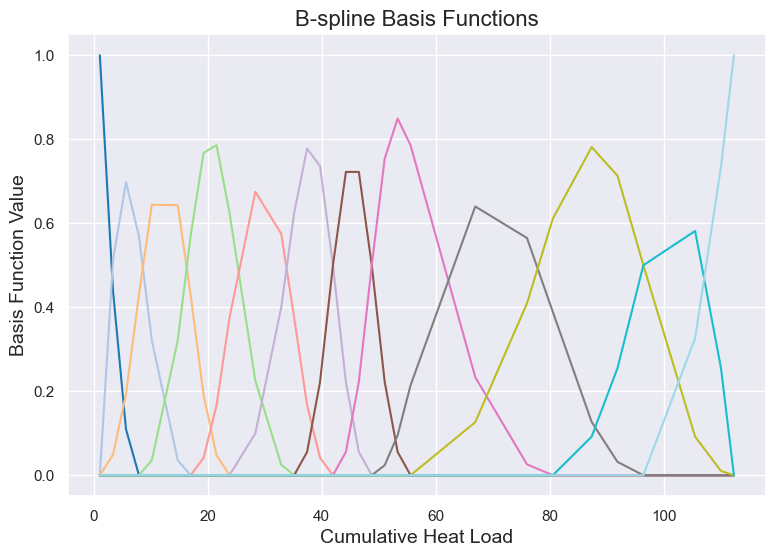

In [50]:
def Phi(a, knots, degree=3, spline_type='B'):
    lower_bound = min(a)
    upper_bound = max(a)
    
    # Adjust knots to ensure they are within the bounds
    knots = np.clip(knots, lower_bound, upper_bound)
    
    if spline_type == 'B':
        B = dmatrix(f"bs(x, knots=knots, degree={degree}, include_intercept=True) - 1", {"x": a, 'knots': knots})
    elif spline_type == 'CR':
        B = dmatrix(f"cr(x, knots=knots, constraints='center')- 1", {"x": a, 'knots': knots})
    elif spline_type == 'CC':
        B = dmatrix(f"cc(x, knots=knots, constraints='center') - 1", {"x": a, 'knots': knots})
    else:
        raise ValueError(f"{spline_type} is not a valid type, choose from 'B', 'CC' or 'CR'")
    return B


for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs+1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Plot Basis Functions (for the random cow)
    if se_number == random_cow:
        color_map = plt.colormaps.get_cmap('tab20')
        colors = color_map(np.linspace(0, 1, B.shape[1]))

        fig = plt.figure(figsize=(9, 6))
        ax = plt.subplot(111)
        for i in range(B.shape[1]):
            c = colors[i]
            ax.plot(x, B[:, i], c=c, label=f'Basis {i + 1}')

        plt.title('B-spline Basis Functions', fontsize=16)
        plt.xlabel('Cumulative Heat Load', fontsize=14)
        plt.ylabel('Basis Function Value', fontsize=14)
        plt.show()

Mean squared error for Cow SE-f454e660-0790 is 0.0142


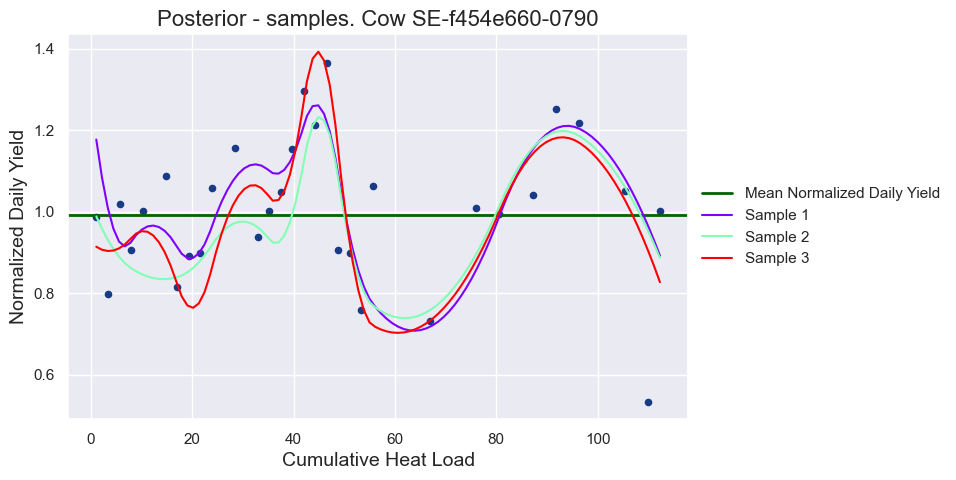

In [51]:
# Seed for reproducibility
np.random.seed(42)

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Check if there are enough data points
    if len(y) < 2:  # If fewer than 2 data points, skip this cow
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Block 3: Bayesian Linear Regression - GAM
    # Calculate empirical priors from the data
    D = B.shape[1]
    m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
    S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

    if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
        print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
        continue

    beta = 1 / np.var(y)

    if np.isinf(beta) or np.isnan(beta):
        print(f"Skipping Cow {se_number} due to invalid beta value.")
        continue

    # Compute the posterior distribution with new priors
    SN = pinv(pinv(S0) + beta * B.T @ B)

    # Adding a small regularization term to ensure positive semi-definiteness
    regularization_term = 1e-6 * np.eye(D)
    SN += regularization_term

    mN = SN @ (pinv(S0) @ m0 + beta * B.T @ y)

    # Print MSE for this cow
    mse = np.mean((y - B @ mN) ** 2)

    # Plot the posterior for the random cow
    if se_number == random_cow:
        print(f"Mean squared error for Cow {se_number} is {mse:.4f}")
        samples = 3
        seed = 100
        ws = multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed)

        n = 100  # number of grid-points
        xs = np.linspace(x.min(), x.max(), n)
        new_data = {'x': xs}

        B_star = build_design_matrices([B.design_info], new_data)[0]
        B_star = np.asarray(B_star)

        # Compute corresponding values f(x*)
        fs = B_star @ ws.T

        # Plot the samples
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        plt.scatter(x, y, color='#183B87', zorder=1, s=20)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

        color = cycle(cm.rainbow(np.linspace(0, 1, samples)))
        for i in range(ws.shape[0]):
            c = next(color)
            line, = ax.plot(xs, fs[:, i], c=c, label=f"Sample {i+1}")

        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)  # Set legend transparency

        plt.title(f'Posterior - samples. Cow {se_number}', fontsize=16)
        plt.xlabel(re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label), fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)  # Updated ylabel

        plt.show()

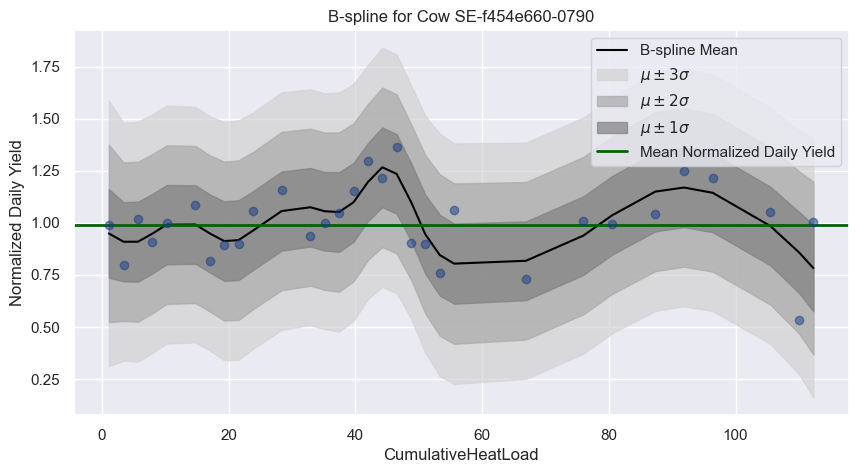

,FarmName_Pseudo,SE_Number,HeatMilkProduction [%],HeatMilkProduction
0,f454e660,SE-f454e660-0139,1.148769,0.011488
1,f454e660,SE-f454e660-0282,1.177820,0.011778
2,f454e660,SE-f454e660-0373,1.541958,0.015420
3,f454e660,SE-f454e660-0374,1.792496,0.017925
4,f454e660,SE-f454e660-0412,1.522694,0.015227
5,f454e660,SE-f454e660-0420,2.574333,0.025743
6,f454e660,SE-f454e660-0422,-2.292616,-0.022926
7,f454e660,SE-f454e660-0444,2.723599,0.027236
8,f454e660,SE-f454e660-0448,-0.001874,-0.000019
9,f454e660,SE-f454e660-0465,4.704596,0.047046


In [52]:
# Seed for reproducibility
np.random.seed(42)

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['FarmName_Pseudo', 'SE_Number', 'HeatMilkProduction [%]'])

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Ensure sufficient data points
    if len(y) < 2:  # Ensure at least 2 data points
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    try:
        # B-Spline Basis Functions (Primary Method)
        degree_spline = 2  # Change the order of the polynomial here
        max_knots = min(len(y) - 1, 10)
        num_qs = max_knots
        knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])
        B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

        # Check if B has more rows than columns
        if B.shape[0] < B.shape[1]:
            raise ValueError(f"Incompatible dimensions (B: {B.shape})")

        # Step 1: Calculate empirical priors from the correct data
        m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
        S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

        if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
            print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
            continue

        # Bayesian Linear Regression
        beta = 1 / np.var(y)
        lambda_ridge = 0.1
        SN = np.linalg.pinv(np.linalg.pinv(S0) + beta * B.T @ B + lambda_ridge * np.eye(B.shape[1]))
        mN = SN @ (np.linalg.pinv(S0) @ m0 + beta * B.T @ y)

        # Make predictions
        mstar_mle = B @ mN
        Sstar_mle = B @ SN @ B.T + beta ** (-1) * np.eye(B.shape[0])
        stdpred_mle = np.sqrt(np.diag(Sstar_mle))
        model_type = 'B-spline'

    except Exception as e:
        print(f"Skipping Cow {se_number} due to incompatible dimensions or another error: {str(e)}")
        continue

    # Integration to calculate HeatMilkProduction
    above_mean = np.maximum(mstar_mle - mean_yield, 0)
    below_mean = np.maximum(mean_yield - mstar_mle, 0)

    # Integrate using the original x values
    area_above_mean = simpson(above_mean, x=x)
    area_below_mean = simpson(below_mean, x=x)

    # Calculate the net area (above - below)
    net_area = area_above_mean - area_below_mean
    range_cum_heatload = x[-1] - x[0]
    net_effect_per_unit = net_area / range_cum_heatload

    # Express the net effect as a percentage of the mean yield
    net_effect_percentage = (net_effect_per_unit / mean_yield) * 100

    # Store results in the DataFrame
    new_result = pd.DataFrame([{
        'FarmName_Pseudo': farm_id,
        'SE_Number': se_number,
        'HeatMilkProduction [%]': net_effect_percentage
    }])

    if results_df.empty:
        results_df = new_result
    else:
        results_df = pd.concat([results_df, new_result], ignore_index=True)

    # Plot for the randomly selected cow
    if se_number == random_cow:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(x, mstar_mle, 'black', label=f'{model_type} Mean')
        ax.fill_between(x, mstar_mle + 3*stdpred_mle, mstar_mle - 3*stdpred_mle, color='lightgray', alpha=0.7, label=r'$\mu \pm 3\sigma$')
        ax.fill_between(x, mstar_mle + 2*stdpred_mle, mstar_mle - 2*stdpred_mle, color='darkgray', alpha=0.7, label=r'$\mu \pm 2\sigma$')
        ax.fill_between(x, mstar_mle + 1*stdpred_mle, mstar_mle - 1*stdpred_mle, color='gray', alpha=0.7, label=r'$\mu \pm 1\sigma$')
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        plt.scatter(x, y, c='#183B87', zorder=4, alpha=0.5)
        ax.legend(loc='best')
        plt.title(f'{model_type} for Cow {se_number}')
        plt.xlabel(f'{input_feature_label}')
        plt.ylabel('Normalized Daily Yield')
        plt.show()

# Display the results
results_df['HeatMilkProduction'] = results_df['HeatMilkProduction [%]'] / 100
results_df

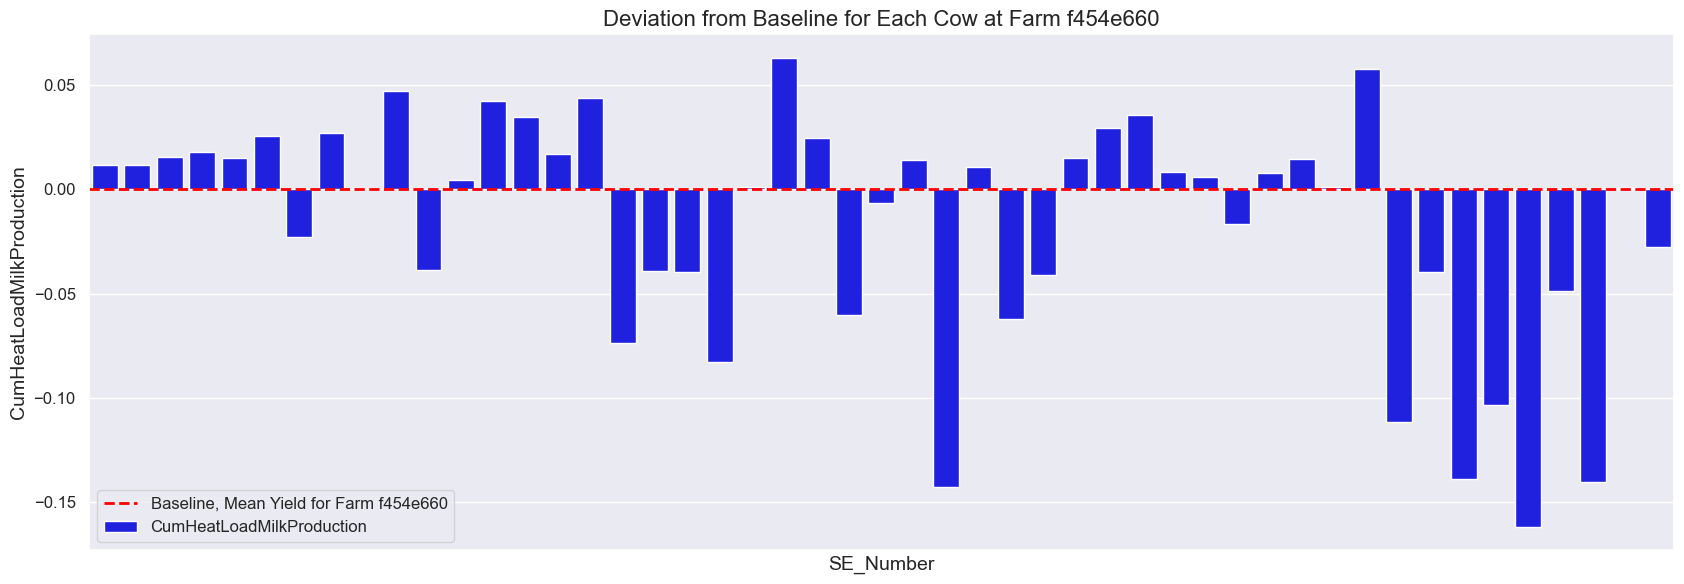

In [53]:
# Create the bar plot
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['HeatMilkProduction'], color='blue', label='CumHeatLoadMilkProduction')

# Add a baseline line set to 0
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')

# Formatting the plot
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('CumHeatLoadMilkProduction', fontsize=14)
plt.title(f'Deviation from Baseline for Each Cow at Farm {farm_id}', fontsize=16)

# Optionally, remove x-axis labels if too many entries
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

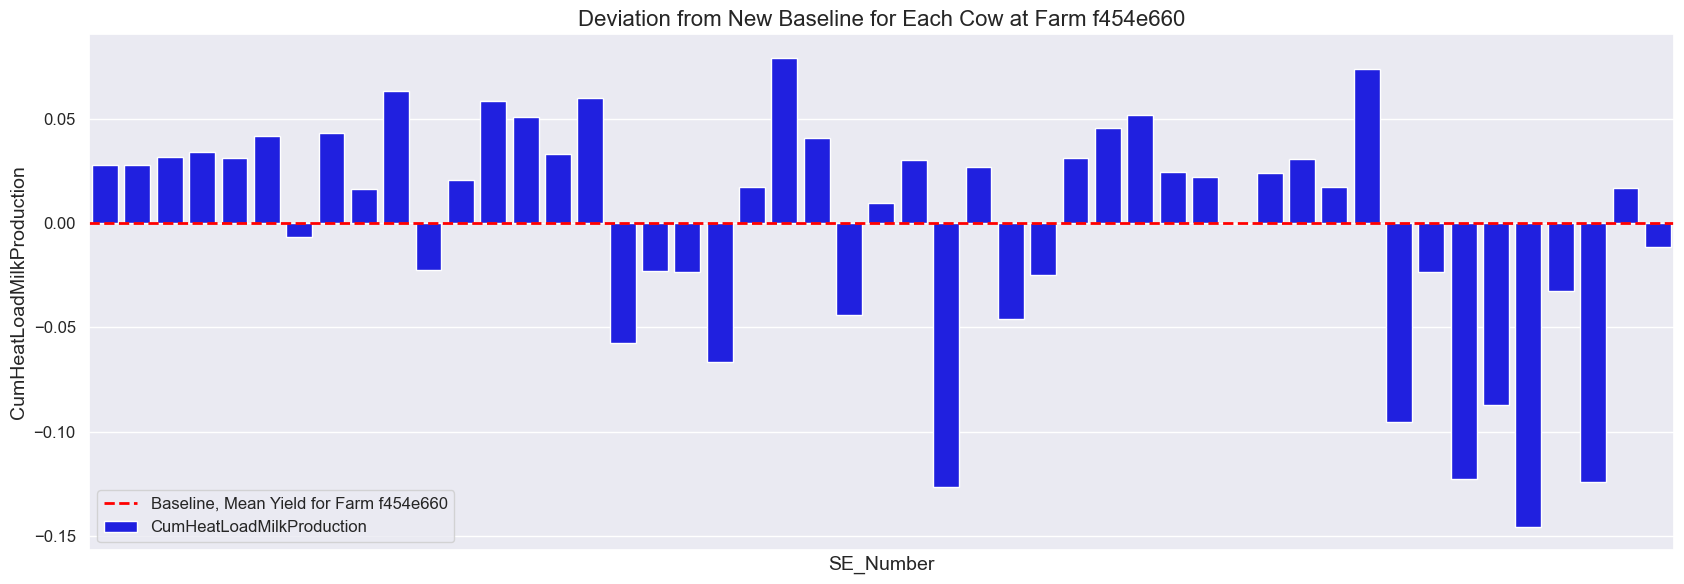

In [54]:
# New baseline value
new_baseline = results_df['HeatMilkProduction'].mean()

# Adjust the HeatMilkProduction to start from the new baseline
results_df['AdjustedHeatMilkProduction'] = results_df['HeatMilkProduction'] - new_baseline

# Create the bar plot
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['AdjustedHeatMilkProduction'], color='blue', label='CumHeatLoadMilkProduction')

# Add a baseline line set to 0 (now adjusted to the new baseline)
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')

# Formatting the plot
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('CumHeatLoadMilkProduction', fontsize=14)
plt.title(f'Deviation from New Baseline for Each Cow at Farm {farm_id}', fontsize=16)

# Optionally, remove x-axis labels if too many entries
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

# Farm 5b581702

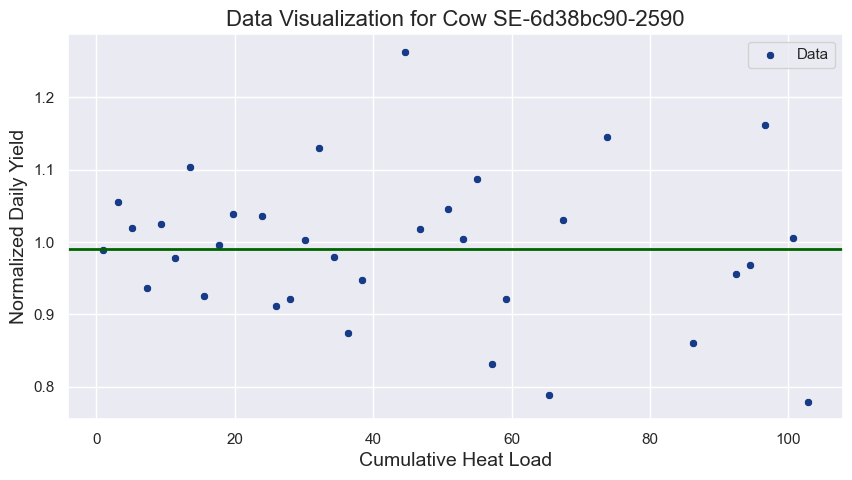

In [55]:
# Filter data for the specific farm
farm_id = '5b581702'
farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm_id]

# Get unique cows (SE_Number) in the farm
unique_cows = farm_data['SE_Number'].unique()

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['FarmName_Pseudo', 'SE_Number', 'CumHeatLoadMilkProduction [%]'])

# Select a random cow for plotting (you can set seed for reproducibility)
np.random.seed(42)  # For reproducibility
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Data Preparation
    N = 50  # Number of bins
    input_feature_label = 'CumulativeHeatLoad'
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Calculate mean_yield for this cow
    mean_yield = cow_data['NormalizedDailyYield'].mean()

    # Initial Visualization (for a random cow only)
    if se_number == random_cow:
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        scatter = sns.scatterplot(x=x, y=y, label='Data', color='#183B87', ax=ax)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        
        plt.title(f"Data Visualization for Cow {se_number}", fontsize=16)
        plt.xlabel('Cumulative Heat Load', fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)
        plt.show()

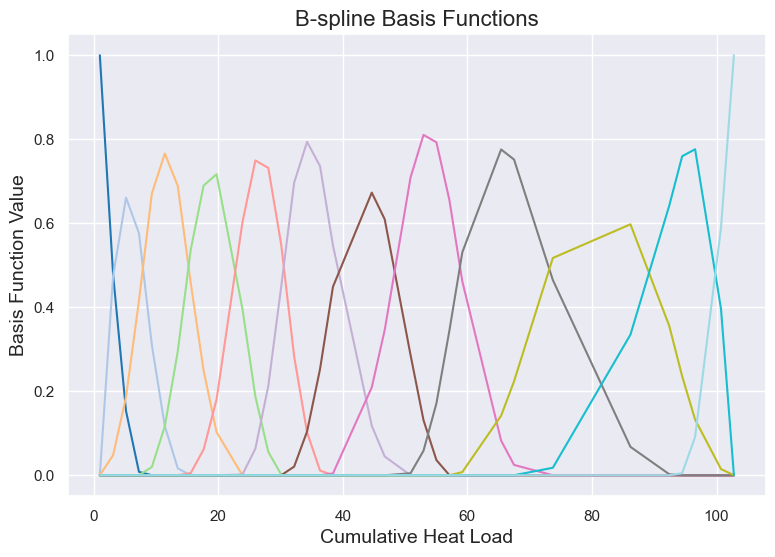

In [56]:
def Phi(a, knots, degree=3, spline_type='B'):
    lower_bound = min(a)
    upper_bound = max(a)
    
    # Adjust knots to ensure they are within the bounds
    knots = np.clip(knots, lower_bound, upper_bound)
    
    if spline_type == 'B':
        B = dmatrix(f"bs(x, knots=knots, degree={degree}, include_intercept=True) - 1", {"x": a, 'knots': knots})
    elif spline_type == 'CR':
        B = dmatrix(f"cr(x, knots=knots, constraints='center')- 1", {"x": a, 'knots': knots})
    elif spline_type == 'CC':
        B = dmatrix(f"cc(x, knots=knots, constraints='center') - 1", {"x": a, 'knots': knots})
    else:
        raise ValueError(f"{spline_type} is not a valid type, choose from 'B', 'CC' or 'CR'")
    return B


for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs+1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Plot Basis Functions (for the random cow)
    if se_number == random_cow:
        color_map = plt.colormaps.get_cmap('tab20')
        colors = color_map(np.linspace(0, 1, B.shape[1]))

        fig = plt.figure(figsize=(9, 6))
        ax = plt.subplot(111)
        for i in range(B.shape[1]):
            c = colors[i]
            ax.plot(x, B[:, i], c=c, label=f'Basis {i + 1}')

        plt.title('B-spline Basis Functions', fontsize=16)
        plt.xlabel('Cumulative Heat Load', fontsize=14)
        plt.ylabel('Basis Function Value', fontsize=14)
        plt.show()

Mean squared error for Cow SE-6d38bc90-2590 is 0.0082


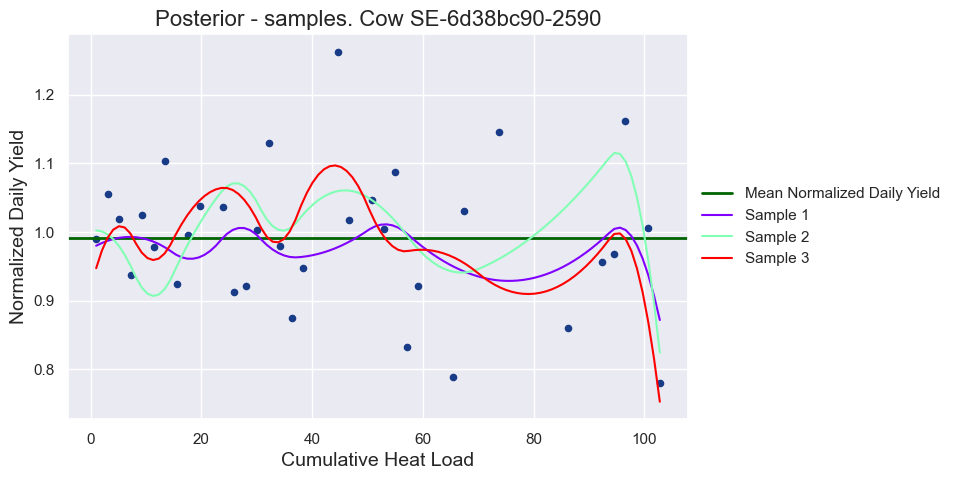

In [57]:
# Seed for reproducibility
np.random.seed(42)

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Check if there are enough data points
    if len(y) < 2:  # If fewer than 2 data points, skip this cow
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Block 3: Bayesian Linear Regression - GAM
    # Calculate empirical priors from the data
    D = B.shape[1]
    m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
    S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

    if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
        print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
        continue

    beta = 1 / np.var(y)

    if np.isinf(beta) or np.isnan(beta):
        print(f"Skipping Cow {se_number} due to invalid beta value.")
        continue

    # Compute the posterior distribution with new priors
    SN = pinv(pinv(S0) + beta * B.T @ B)

    # Adding a small regularization term to ensure positive semi-definiteness
    regularization_term = 1e-6 * np.eye(D)
    SN += regularization_term

    mN = SN @ (pinv(S0) @ m0 + beta * B.T @ y)

    # Print MSE for this cow
    mse = np.mean((y - B @ mN) ** 2)

    # Plot the posterior for the random cow
    if se_number == random_cow:
        print(f"Mean squared error for Cow {se_number} is {mse:.4f}")
        samples = 3
        seed = 100
        ws = multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed)

        n = 100  # number of grid-points
        xs = np.linspace(x.min(), x.max(), n)
        new_data = {'x': xs}

        B_star = build_design_matrices([B.design_info], new_data)[0]
        B_star = np.asarray(B_star)

        # Compute corresponding values f(x*)
        fs = B_star @ ws.T

        # Plot the samples
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        plt.scatter(x, y, color='#183B87', zorder=1, s=20)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

        color = cycle(cm.rainbow(np.linspace(0, 1, samples)))
        for i in range(ws.shape[0]):
            c = next(color)
            line, = ax.plot(xs, fs[:, i], c=c, label=f"Sample {i+1}")

        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)  # Set legend transparency

        plt.title(f'Posterior - samples. Cow {se_number}', fontsize=16)
        plt.xlabel(re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label), fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)  # Updated ylabel

        plt.show()

Skipping Cow SE-5b581702-2138 due to incompatible dimensions or another error: Incompatible dimensions (B: (2, 3))


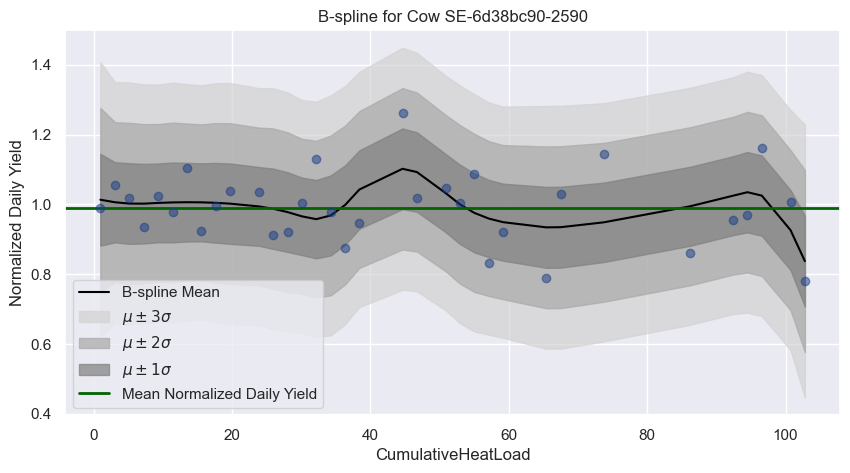

,FarmName_Pseudo,SE_Number,HeatMilkProduction [%],HeatMilkProduction
0,5b581702,SE-27c3257a-1492,0.533159,0.005332
1,5b581702,SE-4b8091ac-1472,2.637529,0.026375
2,5b581702,SE-5b581702-1742,9.373717,0.093737
3,5b581702,SE-5b581702-1755,8.790243,0.087902
4,5b581702,SE-5b581702-1759,4.879996,0.048800
...,...,...,...,...
59,5b581702,SE-5b581702-1802,0.262651,0.002627
60,5b581702,SE-5b581702-1856,3.706609,0.037066
61,5b581702,SE-5b581702-1902,-2.415626,-0.024156
62,5b581702,SE-5b581702-2104,6.031196,0.060312


In [58]:
# Seed for reproducibility
np.random.seed(42)

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['FarmName_Pseudo', 'SE_Number', 'HeatMilkProduction [%]'])

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Ensure sufficient data points
    if len(y) < 2:  # Ensure at least 2 data points
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    try:
        # B-Spline Basis Functions (Primary Method)
        degree_spline = 2  # Change the order of the polynomial here
        max_knots = min(len(y) - 1, 10)
        num_qs = max_knots
        knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])
        B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

        # Check if B has more rows than columns
        if B.shape[0] < B.shape[1]:
            raise ValueError(f"Incompatible dimensions (B: {B.shape})")

        # Step 1: Calculate empirical priors from the correct data
        m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
        S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

        if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
            print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
            continue

        # Bayesian Linear Regression
        beta = 1 / np.var(y)
        lambda_ridge = 0.1
        SN = np.linalg.pinv(np.linalg.pinv(S0) + beta * B.T @ B + lambda_ridge * np.eye(B.shape[1]))
        mN = SN @ (np.linalg.pinv(S0) @ m0 + beta * B.T @ y)

        # Make predictions
        mstar_mle = B @ mN
        Sstar_mle = B @ SN @ B.T + beta ** (-1) * np.eye(B.shape[0])
        stdpred_mle = np.sqrt(np.diag(Sstar_mle))
        model_type = 'B-spline'

    except Exception as e:
        print(f"Skipping Cow {se_number} due to incompatible dimensions or another error: {str(e)}")
        continue

    # Integration to calculate HeatMilkProduction
    above_mean = np.maximum(mstar_mle - mean_yield, 0)
    below_mean = np.maximum(mean_yield - mstar_mle, 0)

    # Integrate using the original x values
    area_above_mean = simpson(above_mean, x=x)
    area_below_mean = simpson(below_mean, x=x)

    # Calculate the net area (above - below)
    net_area = area_above_mean - area_below_mean
    range_cum_heatload = x[-1] - x[0]
    net_effect_per_unit = net_area / range_cum_heatload

    # Express the net effect as a percentage of the mean yield
    net_effect_percentage = (net_effect_per_unit / mean_yield) * 100

    # Store results in the DataFrame
    new_result = pd.DataFrame([{
        'FarmName_Pseudo': farm_id,
        'SE_Number': se_number,
        'HeatMilkProduction [%]': net_effect_percentage
    }])

    if results_df.empty:
        results_df = new_result
    else:
        results_df = pd.concat([results_df, new_result], ignore_index=True)

    # Plot for the randomly selected cow
    if se_number == random_cow:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(x, mstar_mle, 'black', label=f'{model_type} Mean')
        ax.fill_between(x, mstar_mle + 3*stdpred_mle, mstar_mle - 3*stdpred_mle, color='lightgray', alpha=0.7, label=r'$\mu \pm 3\sigma$')
        ax.fill_between(x, mstar_mle + 2*stdpred_mle, mstar_mle - 2*stdpred_mle, color='darkgray', alpha=0.7, label=r'$\mu \pm 2\sigma$')
        ax.fill_between(x, mstar_mle + 1*stdpred_mle, mstar_mle - 1*stdpred_mle, color='gray', alpha=0.7, label=r'$\mu \pm 1\sigma$')
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        plt.scatter(x, y, c='#183B87', zorder=4, alpha=0.5)
        ax.legend(loc='best')
        plt.title(f'{model_type} for Cow {se_number}')
        plt.xlabel(f'{input_feature_label}')
        plt.ylabel('Normalized Daily Yield')
        plt.show()

# Display the results
results_df['HeatMilkProduction'] = results_df['HeatMilkProduction [%]'] / 100
results_df

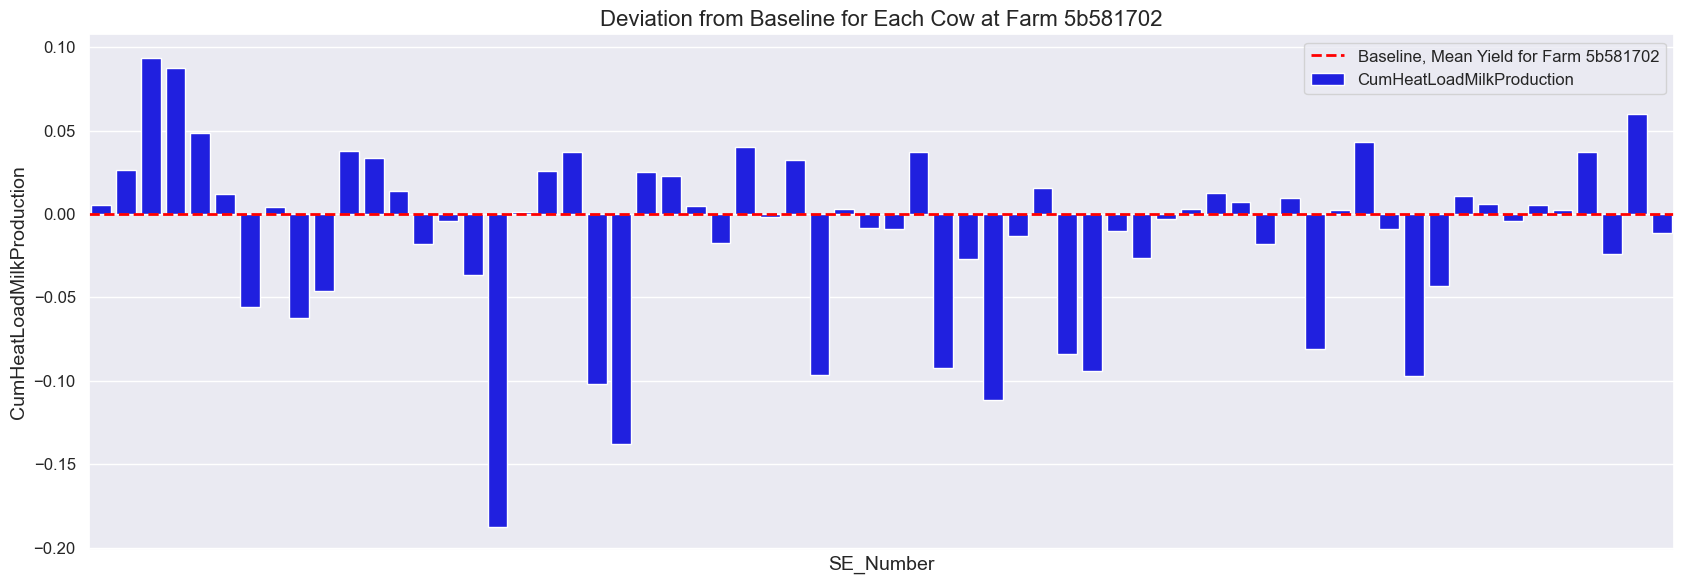

In [59]:
# Create the bar plot
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['HeatMilkProduction'], color='blue', label='CumHeatLoadMilkProduction')

# Add a baseline line set to 0
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')

# Formatting the plot
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('CumHeatLoadMilkProduction', fontsize=14)
plt.title(f'Deviation from Baseline for Each Cow at Farm {farm_id}', fontsize=16)

# Optionally, remove x-axis labels if too many entries
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

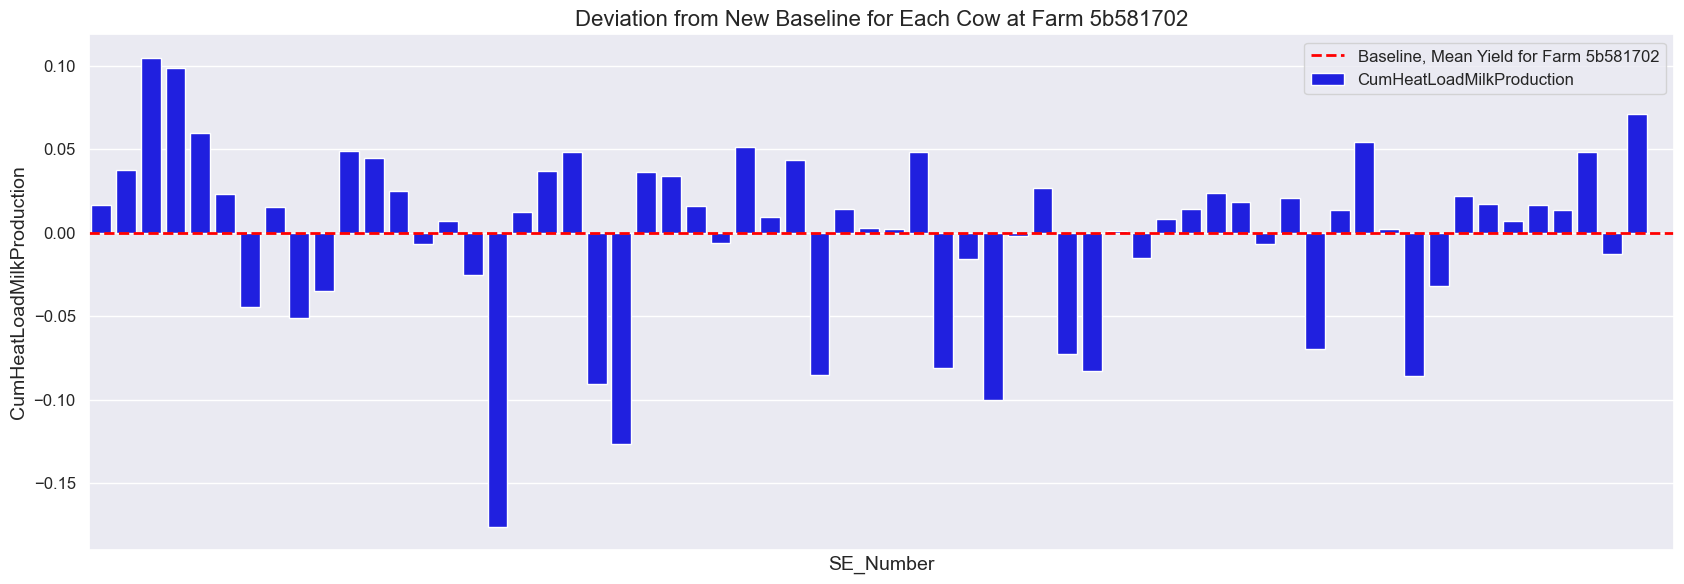

In [60]:
# New baseline value
new_baseline = results_df['HeatMilkProduction'].mean()

# Adjust the HeatMilkProduction to start from the new baseline
results_df['AdjustedHeatMilkProduction'] = results_df['HeatMilkProduction'] - new_baseline

# Create the bar plot
plt.figure(figsize=(17, 6))
sns.barplot(x=results_df.index, y=results_df['AdjustedHeatMilkProduction'], color='blue', label='CumHeatLoadMilkProduction')

# Add a baseline line set to 0 (now adjusted to the new baseline)
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')

# Formatting the plot
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('CumHeatLoadMilkProduction', fontsize=14)
plt.title(f'Deviation from New Baseline for Each Cow at Farm {farm_id}', fontsize=16)

# Optionally, remove x-axis labels if too many entries
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

plt.legend(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()

# Farm ad0a39f5

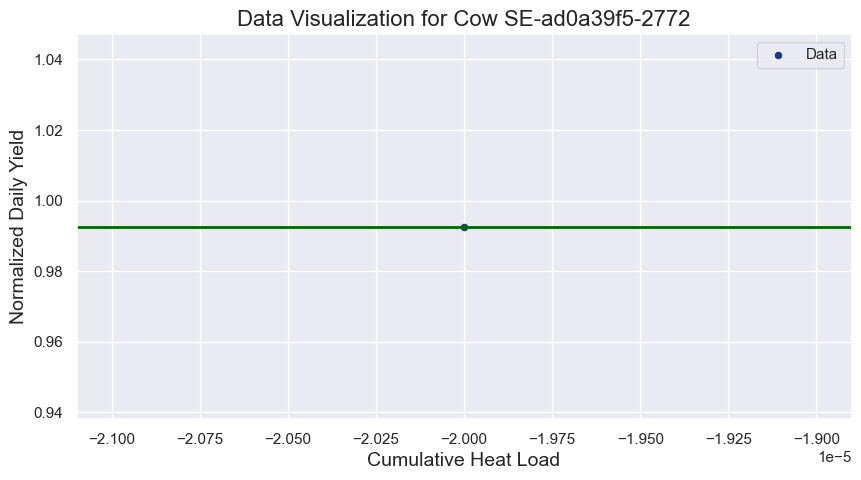

In [61]:
# Filter data for the specific farm
farm_id = 'ad0a39f5'
farm_data = milk_data[milk_data['FarmName_Pseudo'] == farm_id]

# Get unique cows (SE_Number) in the farm
unique_cows = farm_data['SE_Number'].unique()

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['FarmName_Pseudo', 'SE_Number', 'CumHeatLoadMilkProduction [%]'])

# Select a random cow for plotting (you can set seed for reproducibility)
np.random.seed(42)  # For reproducibility
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Data Preparation
    N = 50  # Number of bins
    input_feature_label = 'CumulativeHeatLoad'
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Calculate mean_yield for this cow
    mean_yield = cow_data['NormalizedDailyYield'].mean()

    # Initial Visualization (for a random cow only)
    if se_number == random_cow:
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        scatter = sns.scatterplot(x=x, y=y, label='Data', color='#183B87', ax=ax)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        
        plt.title(f"Data Visualization for Cow {se_number}", fontsize=16)
        plt.xlabel('Cumulative Heat Load', fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)
        plt.show()

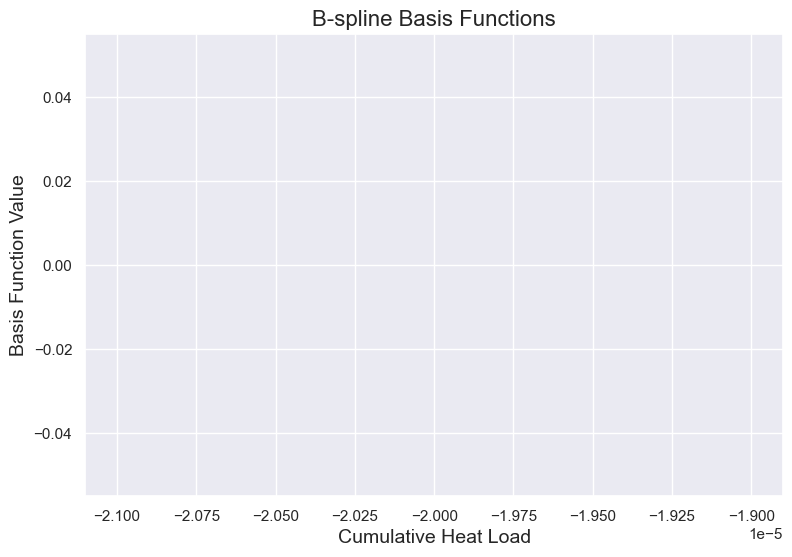

In [62]:
def Phi(a, knots, degree=3, spline_type='B'):
    lower_bound = min(a)
    upper_bound = max(a)
    
    # Adjust knots to ensure they are within the bounds
    knots = np.clip(knots, lower_bound, upper_bound)
    
    if spline_type == 'B':
        B = dmatrix(f"bs(x, knots=knots, degree={degree}, include_intercept=True) - 1", {"x": a, 'knots': knots})
    elif spline_type == 'CR':
        B = dmatrix(f"cr(x, knots=knots, constraints='center')- 1", {"x": a, 'knots': knots})
    elif spline_type == 'CC':
        B = dmatrix(f"cc(x, knots=knots, constraints='center') - 1", {"x": a, 'knots': knots})
    else:
        raise ValueError(f"{spline_type} is not a valid type, choose from 'B', 'CC' or 'CR'")
    return B


for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]
    
    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N) 
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs+1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Plot Basis Functions (for the random cow)
    if se_number == random_cow:
        color_map = plt.colormaps.get_cmap('tab20')
        colors = color_map(np.linspace(0, 1, B.shape[1]))

        fig = plt.figure(figsize=(9, 6))
        ax = plt.subplot(111)
        for i in range(B.shape[1]):
            c = colors[i]
            ax.plot(x, B[:, i], c=c, label=f'Basis {i + 1}')

        plt.title('B-spline Basis Functions', fontsize=16)
        plt.xlabel('Cumulative Heat Load', fontsize=14)
        plt.ylabel('Basis Function Value', fontsize=14)
        plt.show()

In [63]:
# Seed for reproducibility
np.random.seed(42)

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Check if there are enough data points
    if len(y) < 2:  # If fewer than 2 data points, skip this cow
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    # Block 2: B-Spline Basis Functions
    degree_spline = 2  # Change the order of the polynomial here
    num_qs = 10
    knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])

    B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

    # Block 3: Bayesian Linear Regression - GAM
    # Calculate empirical priors from the data
    D = B.shape[1]
    m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
    S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

    if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
        print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
        continue

    beta = 1 / np.var(y)

    if np.isinf(beta) or np.isnan(beta):
        print(f"Skipping Cow {se_number} due to invalid beta value.")
        continue

    # Compute the posterior distribution with new priors
    SN = pinv(pinv(S0) + beta * B.T @ B)

    # Adding a small regularization term to ensure positive semi-definiteness
    regularization_term = 1e-6 * np.eye(D)
    SN += regularization_term

    mN = SN @ (pinv(S0) @ m0 + beta * B.T @ y)

    # Print MSE for this cow
    mse = np.mean((y - B @ mN) ** 2)

    # Plot the posterior for the random cow
    if se_number == random_cow:
        print(f"Mean squared error for Cow {se_number} is {mse:.4f}")
        samples = 3
        seed = 100
        ws = multivariate_normal(mean=mN, cov=SN, allow_singular=True).rvs(samples, random_state=seed)

        n = 100  # number of grid-points
        xs = np.linspace(x.min(), x.max(), n)
        new_data = {'x': xs}

        B_star = build_design_matrices([B.design_info], new_data)[0]
        B_star = np.asarray(B_star)

        # Compute corresponding values f(x*)
        fs = B_star @ ws.T

        # Plot the samples
        fig = plt.figure(figsize=(10, 5))
        ax = plt.subplot(111)
        plt.scatter(x, y, color='#183B87', zorder=1, s=20)

        # Add horizontal line for the mean yield
        mean_yield = cow_data['NormalizedDailyYield'].mean()
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')

        color = cycle(cm.rainbow(np.linspace(0, 1, samples)))
        for i in range(ws.shape[0]):
            c = next(color)
            line, = ax.plot(xs, fs[:, i], c=c, label=f"Sample {i+1}")

        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), framealpha=0)  # Set legend transparency

        plt.title(f'Posterior - samples. Cow {se_number}', fontsize=16)
        plt.xlabel(re.sub(r'([a-z])([A-Z])', r'\1 \2', input_feature_label), fontsize=14)
        plt.ylabel('Normalized Daily Yield', fontsize=14)  # Updated ylabel

        plt.show()

Skipping Cow SE-a756bc39-1048 due to insufficient data points.
Skipping Cow SE-a756bc39-1204 due to insufficient data points.
Skipping Cow SE-a756bc39-1217 due to insufficient data points.
Skipping Cow SE-a756bc39-1218 due to insufficient data points.
Skipping Cow SE-a756bc39-1258 due to insufficient data points.
Skipping Cow SE-a756bc39-1269 due to insufficient data points.
Skipping Cow SE-ad0a39f5-2140 due to insufficient data points.
Skipping Cow SE-ad0a39f5-2305 due to insufficient data points.
Skipping Cow SE-ad0a39f5-2435 due to insufficient data points.
Skipping Cow SE-ad0a39f5-2464 due to insufficient data points.
Skipping Cow SE-ad0a39f5-2474 due to insufficient data points.
Skipping Cow SE-ad0a39f5-2479 due to insufficient data points.
Skipping Cow SE-ad0a39f5-2488 due to insufficient data points.
Skipping Cow SE-ad0a39f5-2536 due to insufficient data points.
Skipping Cow SE-ad0a39f5-2593 due to insufficient data points.
Skipping Cow SE-ad0a39f5-2622 due to insufficient data 

In [64]:
# Seed for reproducibility
np.random.seed(42)

# Initialize an empty DataFrame to store results
results_df = pd.DataFrame(columns=['FarmName_Pseudo', 'SE_Number', 'HeatMilkProduction [%]'])

# Select a random cow for plotting
random_cow = np.random.choice(unique_cows)

for se_number in unique_cows:
    # Filter data for the specific cow
    cow_data = farm_data[farm_data['SE_Number'] == se_number]

    # Create bins and calculate midpoints
    bins = pd.cut(cow_data[input_feature_label], bins=N)
    bin_midpoints = bins.apply(lambda x: x.mid)
    mean_yields = cow_data.groupby(bin_midpoints, observed=True)['NormalizedDailyYield'].mean().reset_index()

    # Assign target y and input vector x
    x = mean_yields[input_feature_label].values
    y = mean_yields.NormalizedDailyYield.values

    # Ensure sufficient data points
    if len(y) < 2:  # Ensure at least 2 data points
        print(f"Skipping Cow {se_number} due to insufficient data points.")
        continue

    try:
        # B-Spline Basis Functions (Primary Method)
        degree_spline = 2  # Change the order of the polynomial here
        max_knots = min(len(y) - 1, 10)
        num_qs = max_knots
        knot_list = np.quantile(x, q=np.linspace(0, 1, num_qs + 1)[1:-1])
        B = Phi(x, knots=knot_list, degree=degree_spline, spline_type='B')

        # Check if B has more rows than columns
        if B.shape[0] < B.shape[1]:
            raise ValueError(f"Incompatible dimensions (B: {B.shape})")

        # Step 1: Calculate empirical priors from the correct data
        m0 = np.linalg.lstsq(B, y, rcond=None)[0]  # Least-squares estimate as prior mean
        S0 = np.cov(B.T)  # Covariance of the design matrix as prior covariance

        if np.any(np.isnan(S0)) or np.any(np.isinf(S0)):
            print(f"Skipping Cow {se_number} due to invalid covariance matrix.")
            continue

        # Bayesian Linear Regression
        beta = 1 / np.var(y)
        lambda_ridge = 0.1
        SN = np.linalg.pinv(np.linalg.pinv(S0) + beta * B.T @ B + lambda_ridge * np.eye(B.shape[1]))
        mN = SN @ (np.linalg.pinv(S0) @ m0 + beta * B.T @ y)

        # Make predictions
        mstar_mle = B @ mN
        Sstar_mle = B @ SN @ B.T + beta ** (-1) * np.eye(B.shape[0])
        stdpred_mle = np.sqrt(np.diag(Sstar_mle))
        model_type = 'B-spline'

    except Exception as e:
        print(f"Skipping Cow {se_number} due to incompatible dimensions or another error: {str(e)}")
        continue

    # Integration to calculate HeatMilkProduction
    above_mean = np.maximum(mstar_mle - mean_yield, 0)
    below_mean = np.maximum(mean_yield - mstar_mle, 0)

    # Integrate using the original x values
    area_above_mean = simpson(above_mean, x=x)
    area_below_mean = simpson(below_mean, x=x)

    # Calculate the net area (above - below)
    net_area = area_above_mean - area_below_mean
    range_cum_heatload = x[-1] - x[0]
    net_effect_per_unit = net_area / range_cum_heatload

    # Express the net effect as a percentage of the mean yield
    net_effect_percentage = (net_effect_per_unit / mean_yield) * 100

    # Store results in the DataFrame
    new_result = pd.DataFrame([{
        'FarmName_Pseudo': farm_id,
        'SE_Number': se_number,
        'HeatMilkProduction [%]': net_effect_percentage
    }])

    if results_df.empty:
        results_df = new_result
    else:
        results_df = pd.concat([results_df, new_result], ignore_index=True)

    # Plot for the randomly selected cow
    if se_number == random_cow:
        fig, ax = plt.subplots(figsize=(10, 5))
        ax.plot(x, mstar_mle, 'black', label=f'{model_type} Mean')
        ax.fill_between(x, mstar_mle + 3*stdpred_mle, mstar_mle - 3*stdpred_mle, color='lightgray', alpha=0.7, label=r'$\mu \pm 3\sigma$')
        ax.fill_between(x, mstar_mle + 2*stdpred_mle, mstar_mle - 2*stdpred_mle, color='darkgray', alpha=0.7, label=r'$\mu \pm 2\sigma$')
        ax.fill_between(x, mstar_mle + 1*stdpred_mle, mstar_mle - 1*stdpred_mle, color='gray', alpha=0.7, label=r'$\mu \pm 1\sigma$')
        ax.axhline(mean_yield, color='#006400', linestyle='-', linewidth=2, label='Mean Normalized Daily Yield')
        plt.scatter(x, y, c='#183B87', zorder=4, alpha=0.5)
        ax.legend(loc='best')
        plt.title(f'{model_type} for Cow {se_number}')
        plt.xlabel(f'{input_feature_label}')
        plt.ylabel('Normalized Daily Yield')
        plt.show()

# Display the results
results_df['HeatMilkProduction'] = results_df['HeatMilkProduction [%]'] / 100
results_df

Skipping Cow SE-a756bc39-1026 due to incompatible dimensions or another error: Incompatible dimensions (B: (9, 10))
Skipping Cow SE-a756bc39-1048 due to insufficient data points.
Skipping Cow SE-a756bc39-1204 due to insufficient data points.
Skipping Cow SE-a756bc39-1217 due to insufficient data points.
Skipping Cow SE-a756bc39-1218 due to insufficient data points.
Skipping Cow SE-a756bc39-1258 due to insufficient data points.
Skipping Cow SE-a756bc39-1262 due to incompatible dimensions or another error: Incompatible dimensions (B: (7, 8))
Skipping Cow SE-a756bc39-1269 due to insufficient data points.
Skipping Cow SE-ad0a39f5-2140 due to insufficient data points.
Skipping Cow SE-ad0a39f5-2305 due to insufficient data points.
Skipping Cow SE-ad0a39f5-2435 due to insufficient data points.
Skipping Cow SE-ad0a39f5-2464 due to insufficient data points.
Skipping Cow SE-ad0a39f5-2474 due to insufficient data points.
Skipping Cow SE-ad0a39f5-2479 due to insufficient data points.
Skipping Cow 

,FarmName_Pseudo,SE_Number,HeatMilkProduction [%],HeatMilkProduction
0,ad0a39f5,SE-a756bc39-0943,-4.504341,-0.045043
1,ad0a39f5,SE-a756bc39-0994,0.126359,0.001264
2,ad0a39f5,SE-a756bc39-1030,0.284241,0.002842
3,ad0a39f5,SE-a756bc39-1141,1.831979,0.018320
4,ad0a39f5,SE-a756bc39-1143,0.653072,0.006531
...,...,...,...,...
147,ad0a39f5,SE-ad0a39f5-2717,-1.297407,-0.012974
148,ad0a39f5,SE-ad0a39f5-2721,0.173822,0.001738
149,ad0a39f5,SE-ad0a39f5-2728,-2.317591,-0.023176
150,ad0a39f5,SE-ad0a39f5-2746,-3.902616,-0.039026


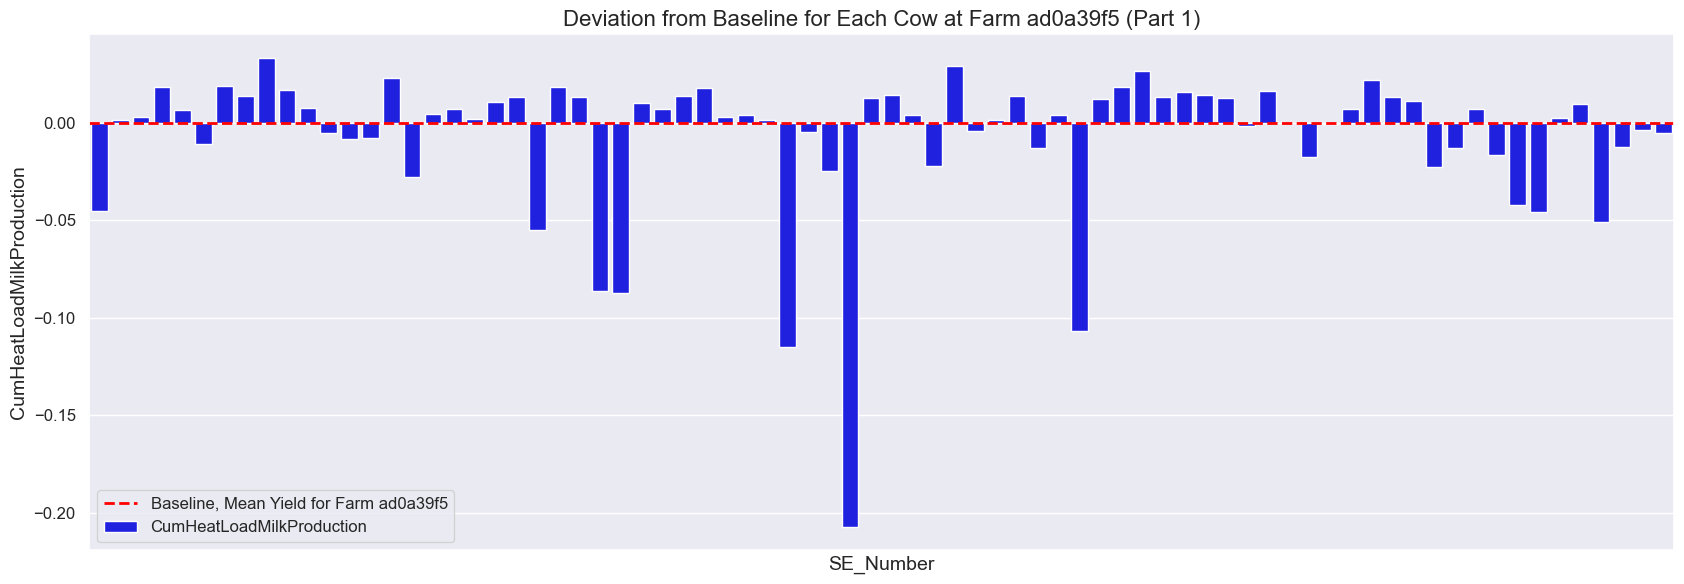

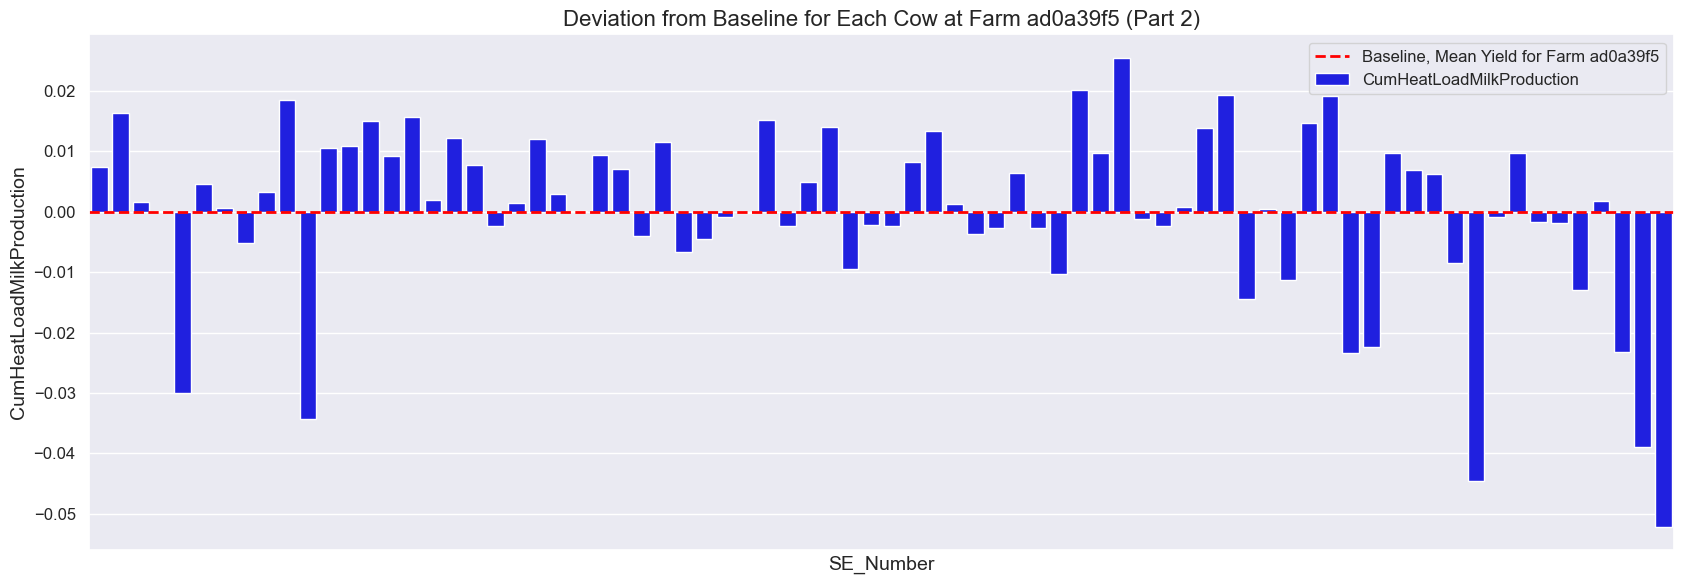

In [65]:
# Calculate the midpoint to split the data into two halves
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['HeatMilkProduction'], color='blue', label='CumHeatLoadMilkProduction')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('CumHeatLoadMilkProduction', fontsize=14)
plt.title(f'Deviation from Baseline for Each Cow at Farm {farm_id} (Part 1)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['HeatMilkProduction'], color='blue', label='CumHeatLoadMilkProduction')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('CumHeatLoadMilkProduction', fontsize=14)
plt.title(f'Deviation from Baseline for Each Cow at Farm {farm_id} (Part 2)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

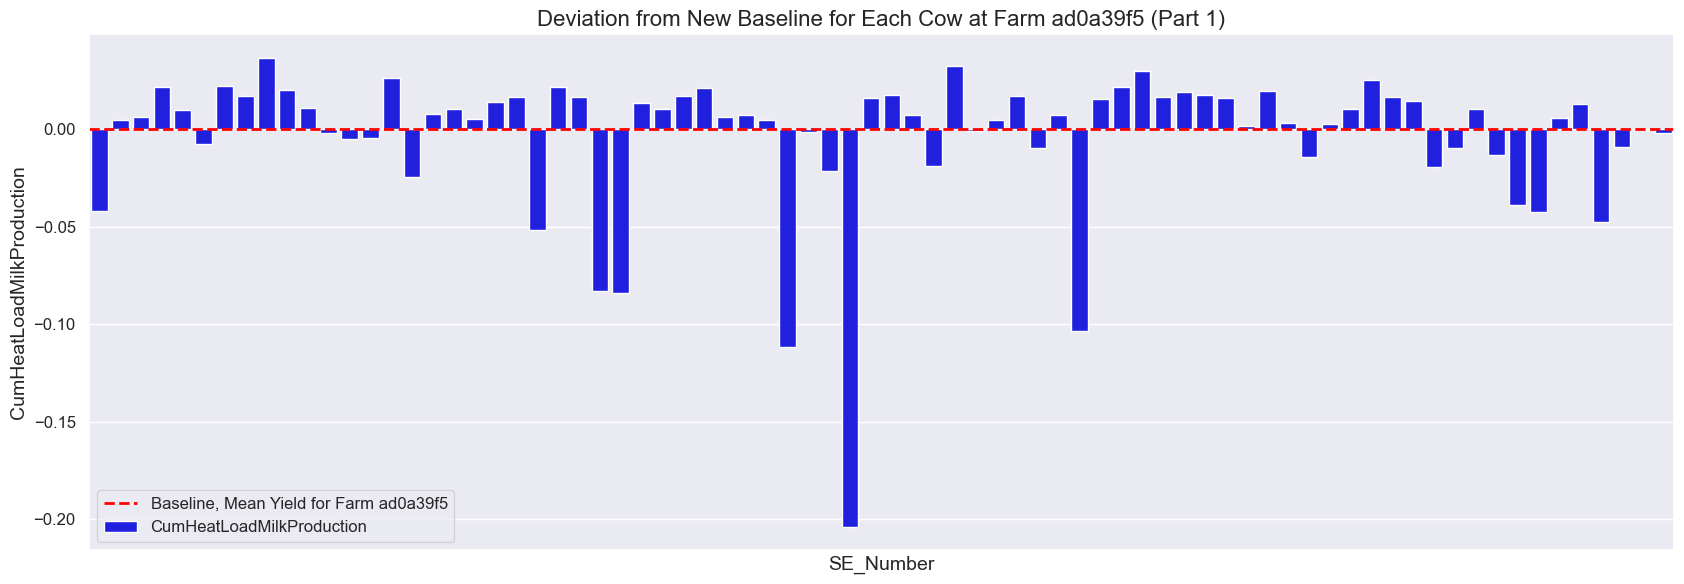

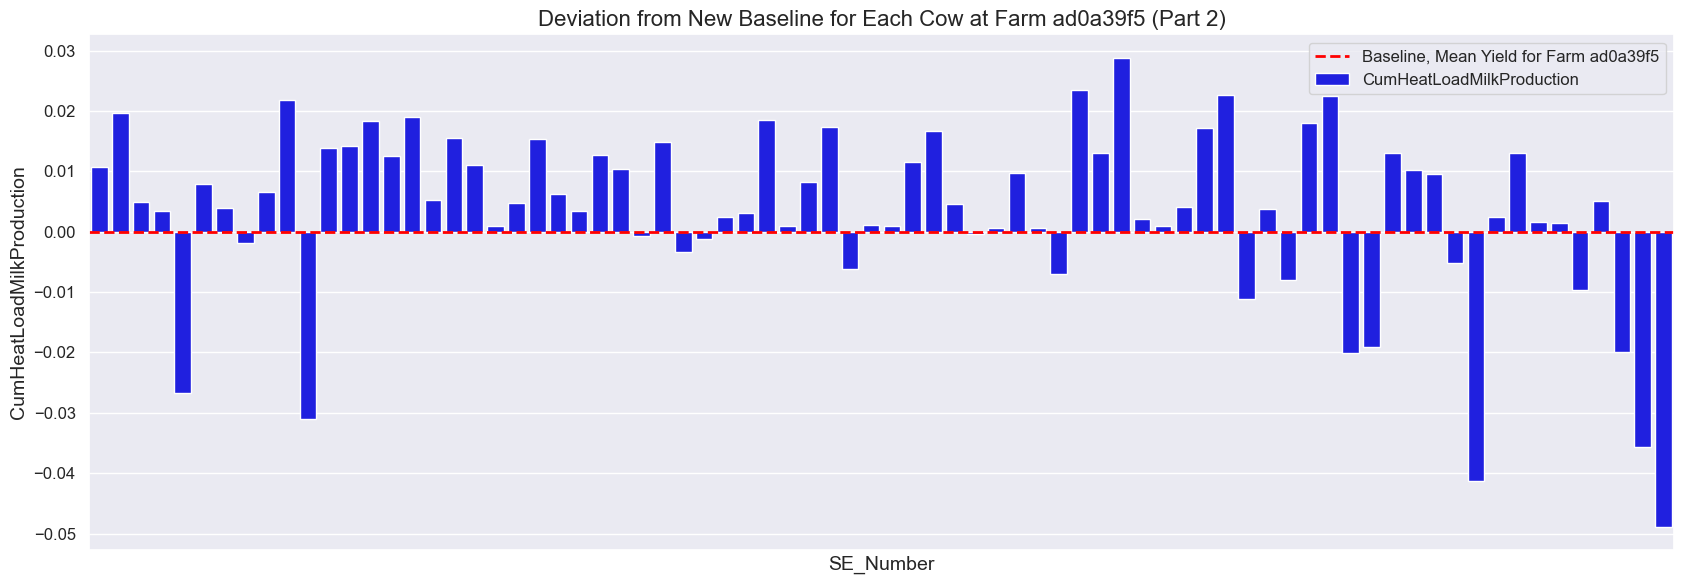

In [66]:
# New baseline value
new_baseline = results_df['HeatMilkProduction'].mean()

# Adjust the HeatMilkProduction to start from the new baseline
results_df['AdjustedHeatMilkProduction'] = results_df['HeatMilkProduction'] - new_baseline

# Calculate the midpoint to split the data into two halves
midpoint = len(results_df) // 2

# Split the data into two halves
first_half = results_df.iloc[:midpoint]
second_half = results_df.iloc[midpoint:]

# Plotting for the first half
plt.figure(figsize=(17, 6))
sns.barplot(x=first_half.index, y=first_half['AdjustedHeatMilkProduction'], color='blue', label='CumHeatLoadMilkProduction')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('CumHeatLoadMilkProduction', fontsize=14)
plt.title(f'Deviation from New Baseline for Each Cow at Farm {farm_id} (Part 1)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# Plotting for the second half
plt.figure(figsize=(17, 6))
sns.barplot(x=second_half.index, y=second_half['AdjustedHeatMilkProduction'], color='blue', label='CumHeatLoadMilkProduction')
plt.axhline(0, color='red', linestyle='--', linewidth=2, label=f'Baseline, Mean Yield for Farm {farm_id}')
plt.xlabel('SE_Number', fontsize=14)
plt.ylabel('CumHeatLoadMilkProduction', fontsize=14)
plt.title(f'Deviation from New Baseline for Each Cow at Farm {farm_id} (Part 2)', fontsize=16)
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
plt.legend(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()